# Fraction of Gas Loss
## Summer 2023
### Author: Mitsuru Watanabe

**Key findings**
- Fractional Gas Loass is perhaps higher just prior to 1 virial radius away from the host (indication of "boosted" ram pressure stripping)
- Boosting of ram pressure is perhaps more significant for smaller galaxies
- Boosting of ram pressure is perhaps more significant for expelled SN-heated gas than discharged SN-heated gas


Stepping forward from `dischargedgastracking.ipynb`, here I analyze the fraction of SN-heated discharged gas to SN-heated all gas over time to find the relation of gas loss due to SN-heating to before and after infall. I specifically look at time before reaching 1 virial radius from the host galaxy, since we found in infalling analysis that around this time, SFR increases with decreasing distance from host to the satellite. I found out by looking at the average fraction discharged/expelled that fraction of gas loss at post 1 Rvir is bigger than pre 1 Rvir, and this is true for both discharged gas and expelled gas. I can confirm, also by looking at the mass loading factor plots from dischargedgastracking code that the ram pressure stripping is effectively browing the gas to outside when the galaxy is at a closer distance to the host, and this is more significant for smaller galaxies than massive ones. This work is followed by `F23_SNe_Gas_Loss,ipynb`.

In [1]:
import h5py
from base import *
from analysis import * 
from compiler import *

path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/heated_all_particles.hdf5'
with h5py.File(path) as data:
    print(len(data.keys()), 'Available keys:', *data.keys())

base.py executed
compiler.py executed
28 Available keys: h148_10 h148_12 h148_2 h148_249 h148_251 h148_27 h148_282 h148_3 h148_34 h148_38 h148_4 h148_55 h148_6 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_10 h242_21 h242_30 h242_38 h242_69 h242_8 h329_117 h329_29 h329_7


In [2]:
def read_one_expelled(key):
    
    expelled = pd.DataFrame()
    preexpelled = pd.DataFrame()
    expelled = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5', key=key)
    preexpelled = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5', key=key)

    return preexpelled, expelled

In [9]:
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']


preexpelled, expelled = read_one_expelled('h329_7')
expelled.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
126713,13.262072,164443,0.000118,35127.843750,27204.221237,13.048770,10.053019,0.259517,-1.009866,-9.236422,...,5.213246,False,True,False,False,False,False,6.436547e+09,79.838180,True
108621,12.938837,164635,0.028976,10083.291992,26629.664106,0.000000,2.705981,0.069987,-0.978155,1.304508,...,4.121910,False,True,False,False,False,False,6.550984e+09,93.813379,False
108623,12.938837,164648,0.000449,15654.036133,26754.305851,12.738162,6.443705,0.166658,-3.721039,-3.154299,...,4.121910,False,True,False,False,False,False,6.550984e+09,43.433449,True
36226,11.969131,164680,0.005232,12267.616211,26690.190615,10.881247,3.963844,0.103898,-2.709491,-2.751942,...,5.092050,False,True,False,False,False,False,6.814673e+09,114.652653,False
108635,12.938837,164704,0.010581,11073.396484,26609.706782,12.011726,3.141679,0.081255,-1.061778,-2.853469,...,4.121910,False,True,False,False,False,False,6.550984e+09,98.779589,False


## Get the fraction of sn discharged/sn

In [113]:
sim = 'h148'
haloid = 10

particles = read_tracked_particles(sim, haloid)

#all SN-heated gas, which doesn't have to be discharged
coolontime_arr=np.unique(list(zip(particles.index, *map(particles.get, ['pid','time','coolontime']))), axis=0)
disabled_gas_arr = coolontime_arr[1:][coolontime_arr[1:,3]>coolontime_arr[:-1,2]]

indexHeated = disabled_gas_arr[:,0]
heated_all = particles[particles.index.isin(indexHeated)]

> Returning <tracked_particle> dataset <


In [5]:
more_heated2 = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/more_heated_particles.hdf5', key='h148_10')

In [3]:
import tqdm
def calc_snHeated(particles):
    """
    This function detects the gas particles that are sn-heated by comparing the coolontime 
    with the time 1 timestep before. Since the detection of sn-heating doesn't depend on any positional argument,
    this includes gas particles being SN-heated at any point. However, in order to avoid counting gas particles
    that are outside the satellite, as those are likely not heated by the satellite, 
    we should constrain only within the satellite.
    """
    #iterate detection process by pids
    pids = np.unique(particles['pid'])
    index = np.array([]) #initialize
    for pid in tqdm.tqdm(pids):
        data = particles[particles['pid']==pid]
        #create a structured array, containing index of dataframe, pid, time, and coolontime
        dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
        structureArray=np.array(list(zip(data.index, *map(data.get, ['pid','time','coolontime']))), dtype=dtype)
        #limit to after being heated (avoid mistakingly take the row heated at the same timestep)
        heatedArray=structureArray[structureArray['time']>structureArray['coolontime']]
        #extract the list of unique coolontime, sorted by pid and time
        helper1, helper2 = np.unique(heatedArray['coolontime'], return_index = True)
        heatedunique = np.sort(heatedArray[helper2], order=['pid','time'])

        timebefore = heatedunique['time'][:-1]
        #find sn-heated list by comparing the time before and coolontime
        heatedLocal = heatedunique[1:][heatedunique['coolontime'][1:]>timebefore]
        indexLocal = heatedLocal['index'].astype(int)
        index = np.append(index, indexLocal)
    #based on detected indices, find the designated rows from original dataframe
    heated = particles[particles.index.isin(index)] 
    #drop if gas is outside satellite (e.g. host, other sat, IGM)
    heated = heated[heated['in_sat']==True]

    return heated

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


/tmp/ipykernel_25924/748910392.py:30: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_25924/748910392.py:31: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


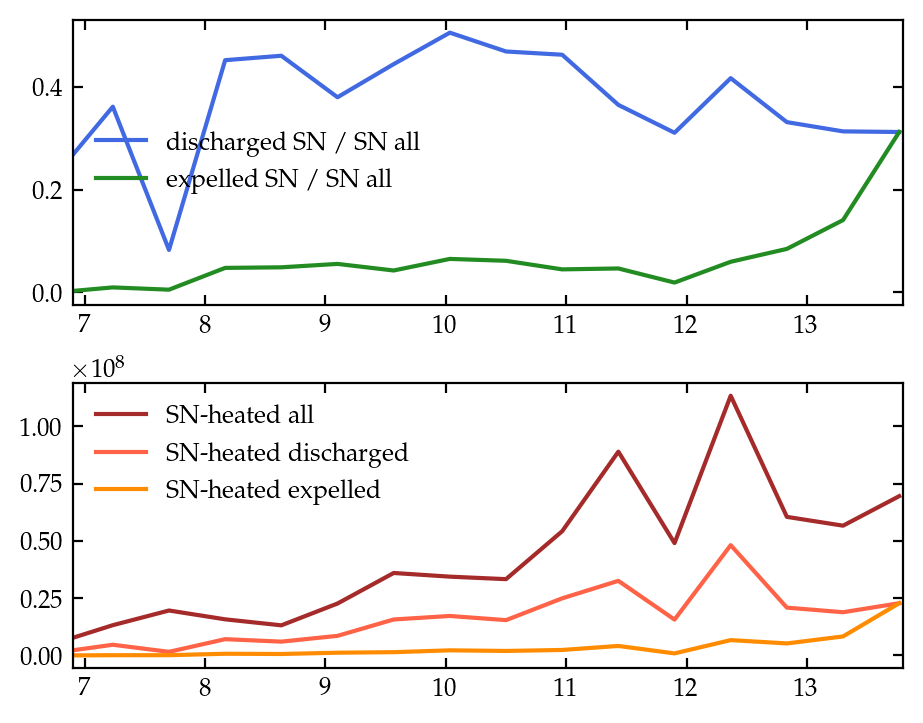

In [124]:
#fraction of discharged/heated (archive)
# all discharged gas
bins = 30
rangeMax = 14

#load particles
sim = 'h148'
haloid = 10
particles = read_tracked_particles(sim, haloid)

#discharged sn-heated gas, binned
_, discharged = read_one_discharged('h148_10')
heated_dis = calc_snHeated(discharged)
dist, x = np.histogram(heated_dis.time, bins=bins, range=(0,rangeMax))

# all snheated gas, binned
heated_all = calc_snHeated(particles)
snt, x = np.histogram(heated_all.time, bins=bins, range=(0,rangeMax))

#expelled sn-heated gas, binned
_, expelled = read_one_expelled('h148_10')
heated2 = calc_snHeated(expelled)
expt, x = np.histogram(heated2.time, bins=bins, range=(0,rangeMax))

# computing fraction dist/snt at each radial position.
fracDis = np.array([])
fracExp = np.array([])

for i in range(0, bins):
    ratioDis = dist[i]/snt[i]
    ratioExp = expt[i]/snt[i]
    fracDis = np.append(fracDis,ratioDis)
    fracExp = np.append(fracExp,ratioExp)
    i += 1


fig, ax = plt.subplots(2,1,figsize = (4.5,3.5))
# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax[0].plot(bincenters, fracDis, c = 'royalblue', label='discharged SN / SN all')
ax[0].plot(bincenters, fracExp, c = 'forestgreen', label='expelled SN / SN all')
ax[0].set_xlim(np.min(heated_dis.time), np.max(heated_dis.time))
ax[0].legend(fontsize=7,loc='upper left')

# mass distributions:
# all snheated gas
snall, x = np.histogram(heated_all.time, bins=bins, weights=heated_all.mass, range=(0,rangeMax))
snexpelled, x = np.histogram(heated2.time, bins=bins, weights=heated2.mass, range=(0,rangeMax))
sndischarged, x = np.histogram(heated_dis.time, bins=bins, weights=heated_dis.mass, range=(0,rangeMax))

bincenters = 0.5*(x[1:] + x[:-1])
ax[1].plot(bincenters, snall, label='SN-heated all', c='brown')
ax[1].plot(bincenters, sndischarged, label='SN-heated discharged', c='tomato')
ax[1].plot(bincenters, snexpelled, label='SN-heated expelled', c='darkorange')
ax[1].set_xlim(np.min(heated_dis.time), np.max(heated_dis.time))
ax[1].legend(fontsize=7,loc='upper left')

In [6]:
import time
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']
start = time.time()

#run calc_snHeated for all the satellites
for key in keys:
    #load particles
    sim = str(key[:4])
    haloid = int(key[5:])
    particles = read_tracked_particles(sim, haloid)
    
    #then calculate sn-heated gas
    heated_all = calc_snHeated(particles) #8/2 redefined to only include in_sat gas
    
    #save
    filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/heated_all_particles.hdf5'
    heated_all.to_hdf(filepath, key=key)
    
end = time.time()
time = end - start
print("Program finished execution: ", time, " s")
#this takes a while to finish (< 7 hrs)

> Returning <tracked_particle> dataset <


100%|████████████████████████████████████| 89554/89554 [03:07<00:00, 477.41it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 9978/9978 [00:06<00:00, 1651.85it/s]


> Returning <tracked_particle> dataset <


100%|██████████████████████████████████| 496963/496963 [34:06<00:00, 242.86it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 6264/6264 [00:03<00:00, 1592.75it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 5081/5081 [00:03<00:00, 1583.38it/s]


> Returning <tracked_particle> dataset <


100%|████████████████████████████████████| 53018/53018 [01:57<00:00, 450.68it/s]


> Returning <tracked_particle> dataset <


100%|███████████████████████████████████| 10641/10641 [00:06<00:00, 1541.47it/s]


> Returning <tracked_particle> dataset <


100%|██████████████████████████████████| 227593/227593 [11:03<00:00, 343.07it/s]


> Returning <tracked_particle> dataset <


100%|███████████████████████████████████| 10219/10219 [00:06<00:00, 1669.52it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 7533/7533 [00:04<00:00, 1718.55it/s]


> Returning <tracked_particle> dataset <


100%|████████████████████████████████████| 66283/66283 [01:06<00:00, 990.50it/s]


> Returning <tracked_particle> dataset <


100%|███████████████████████████████████| 11707/11707 [00:07<00:00, 1513.96it/s]


> Returning <tracked_particle> dataset <


100%|████████████████████████████████████| 75668/75668 [01:16<00:00, 987.92it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 6098/6098 [00:03<00:00, 1659.68it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 7885/7885 [00:04<00:00, 1597.43it/s]


> Returning <tracked_particle> dataset <


100%|███████████████████████████████████| 15178/15178 [00:11<00:00, 1281.78it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 2239/2239 [00:01<00:00, 1552.80it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 1968/1968 [00:01<00:00, 1493.75it/s]


> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 2605/2605 [00:01<00:00, 1587.29it/s]


> Returning <tracked_particle> dataset <


 60%|████████████████████▍             | 129543/215339 [09:45<06:58, 204.79it/s]

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


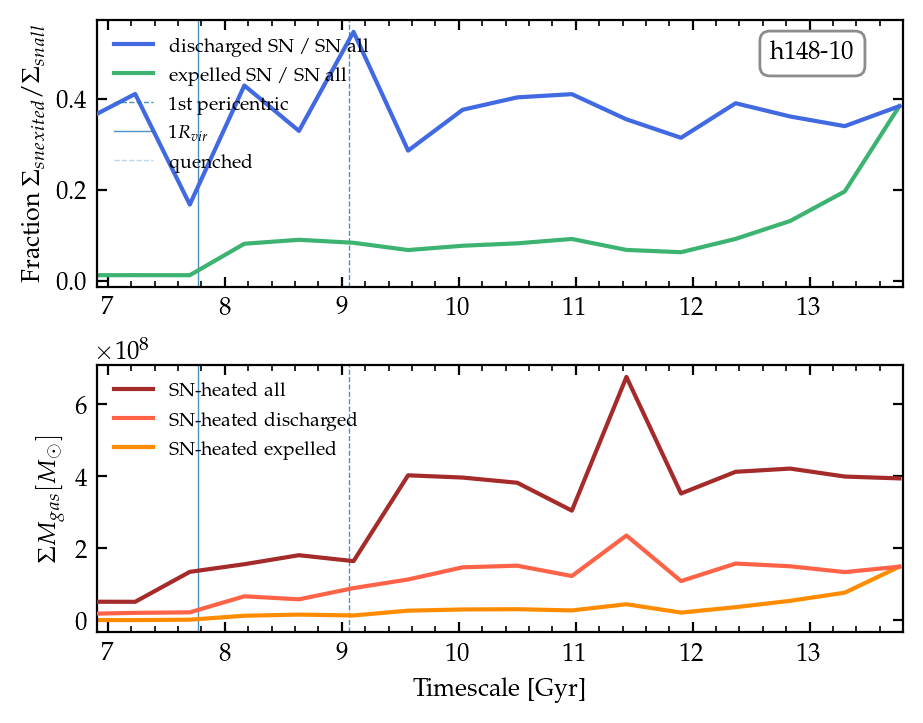

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


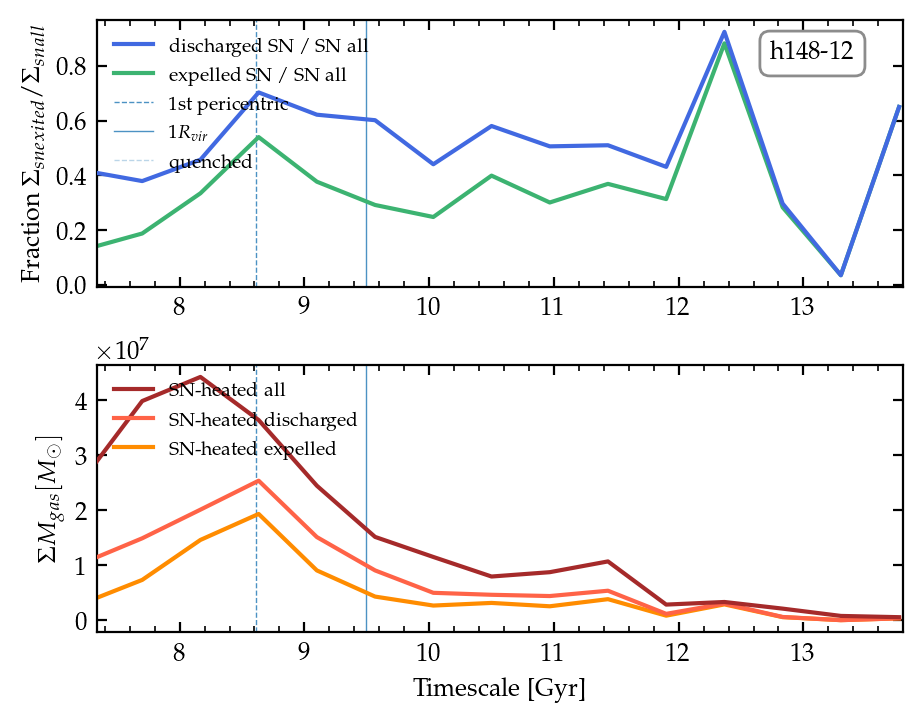

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_2 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


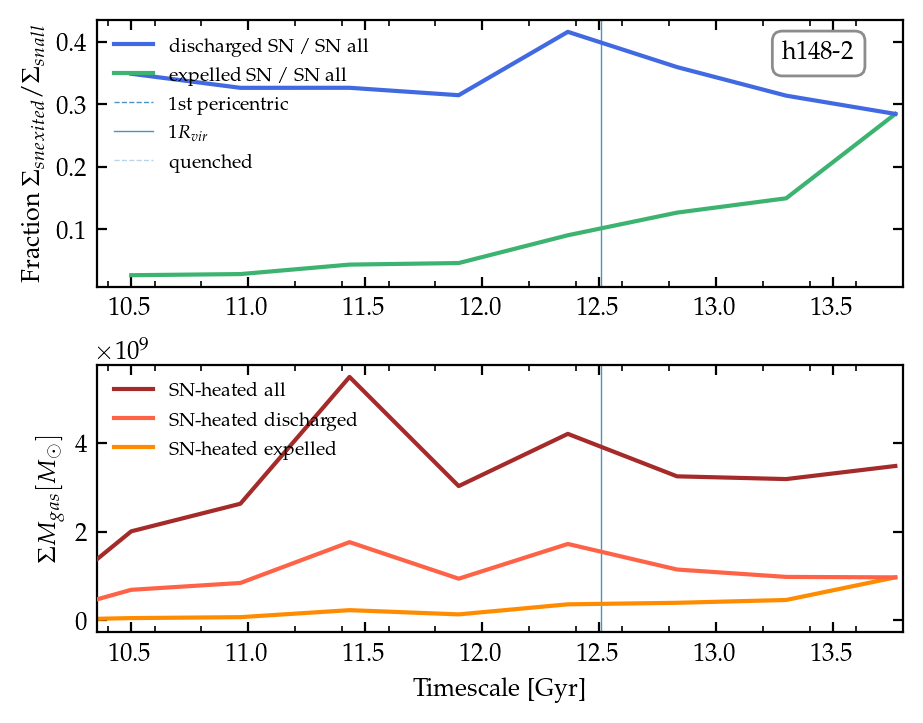

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_249 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


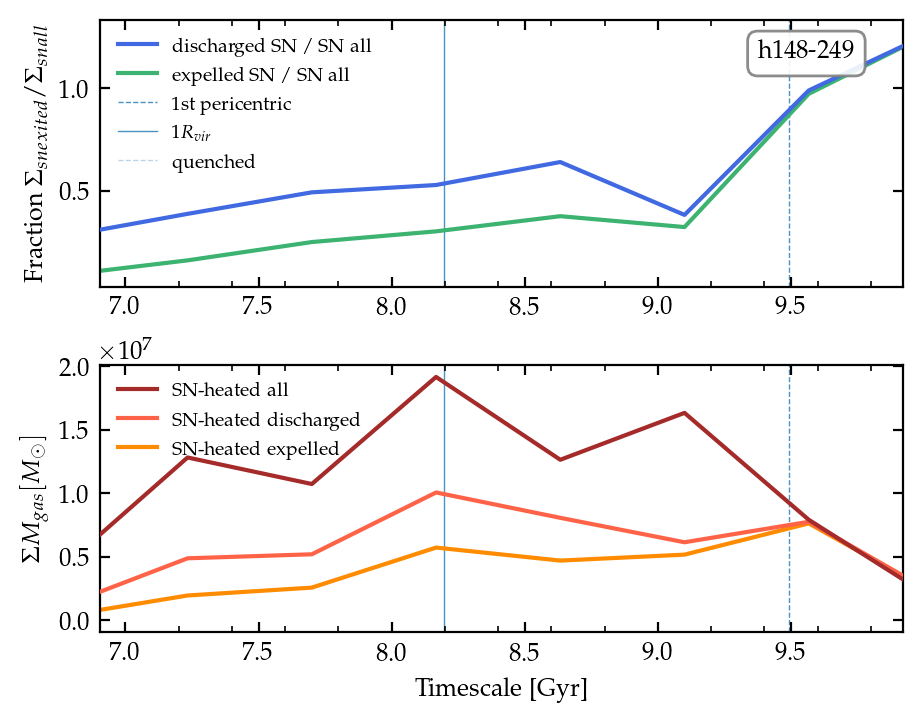

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_251 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


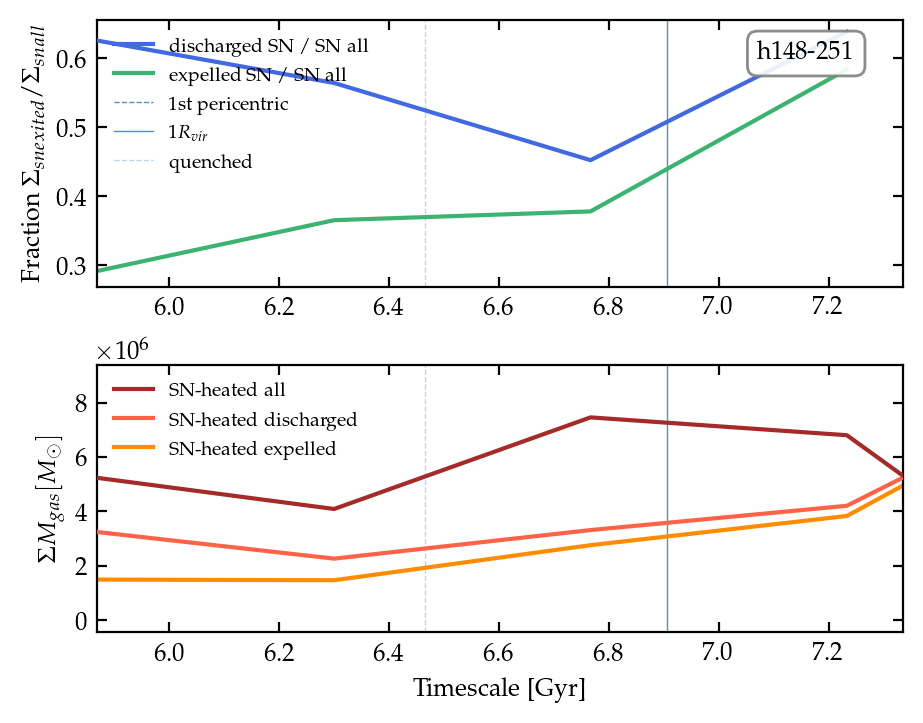

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_27 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


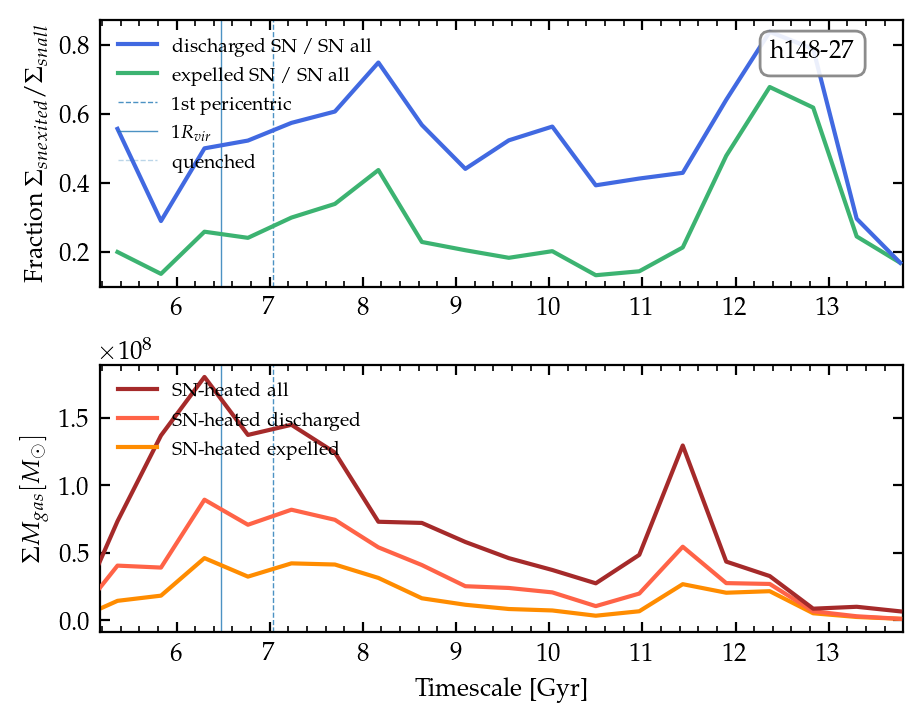

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_282 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


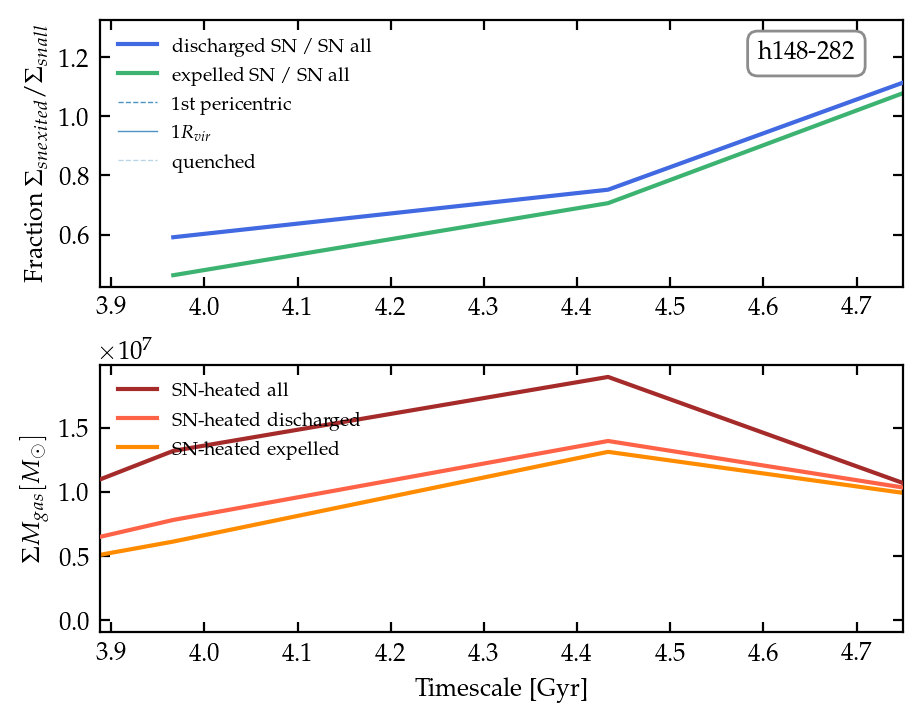

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_3 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


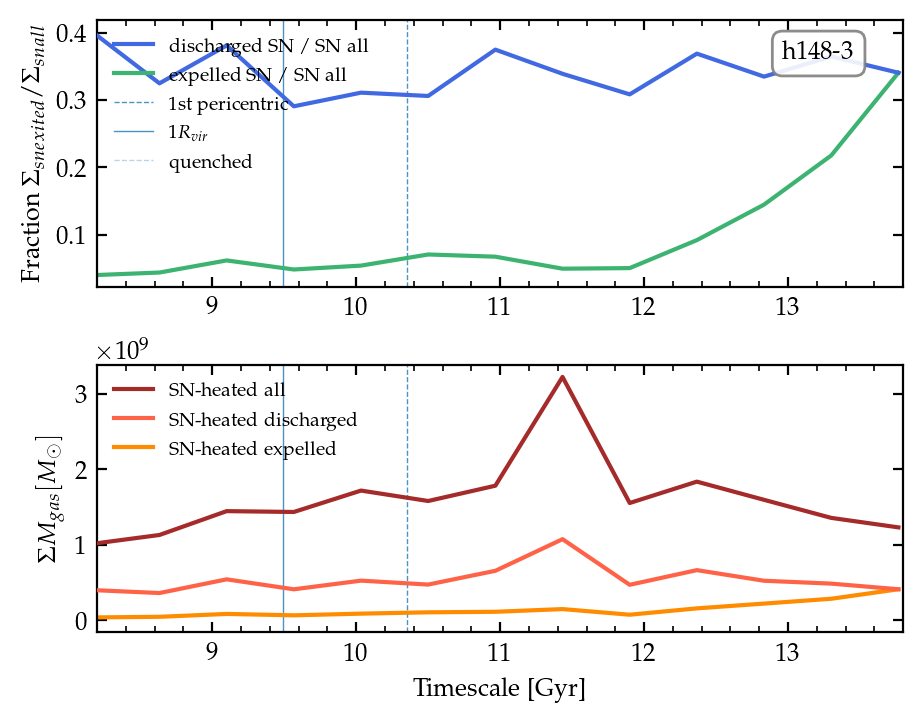

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_34 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


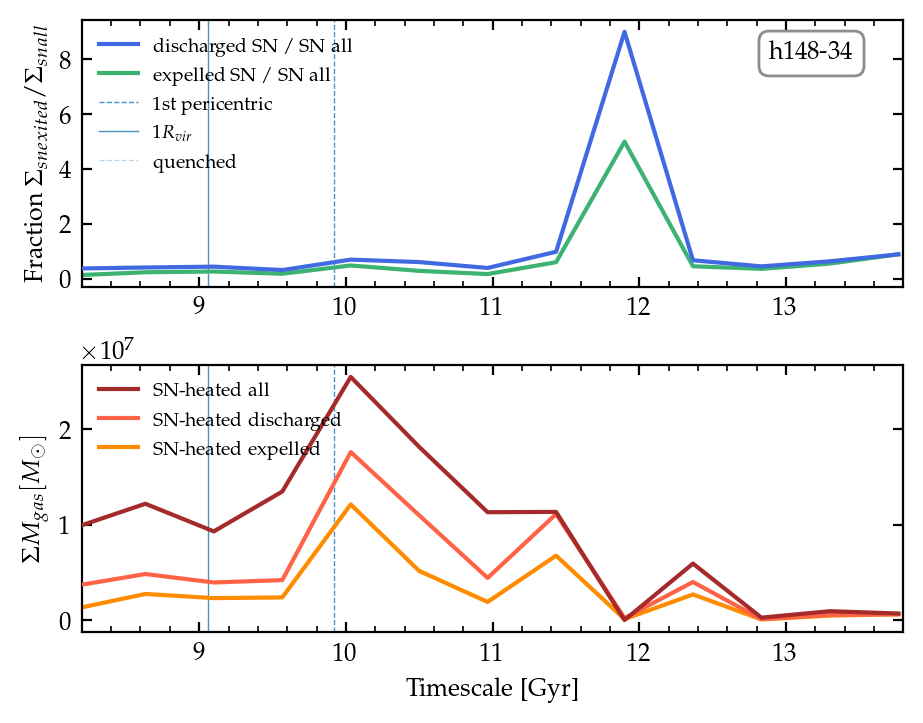

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_38 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


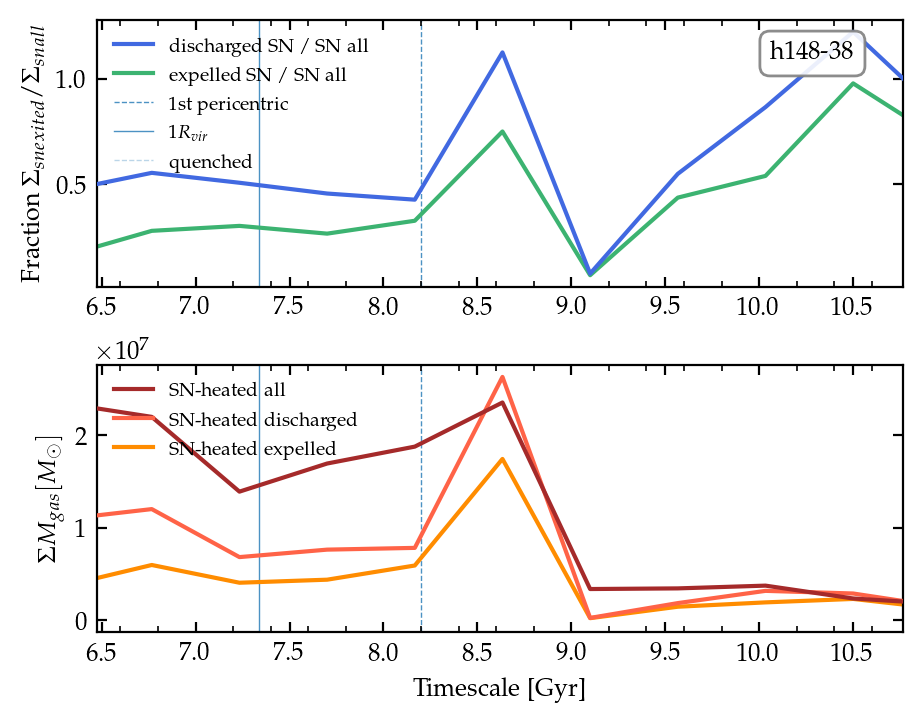

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_4 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


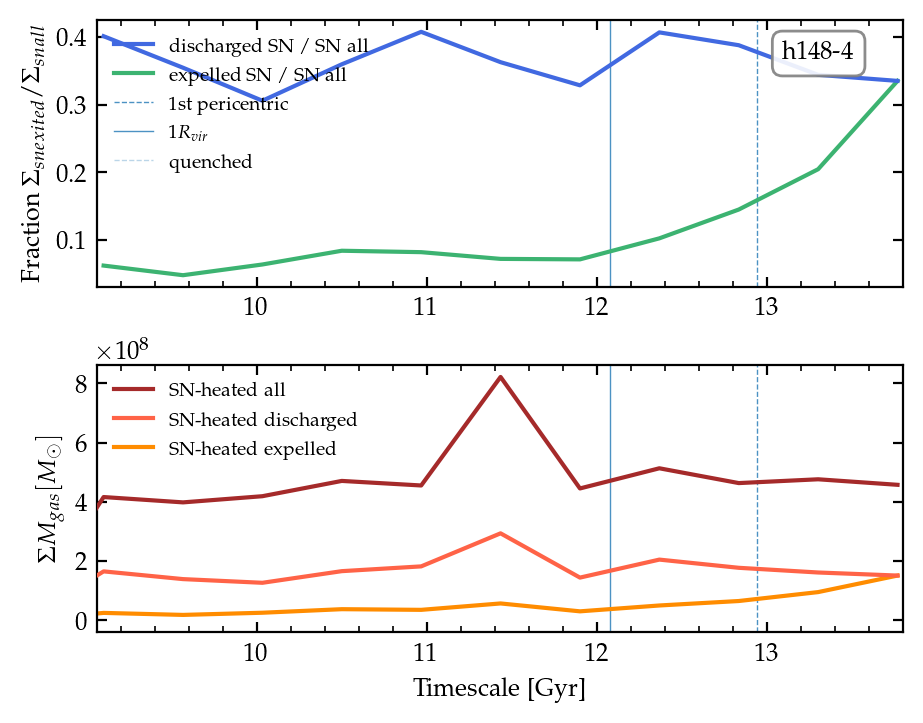

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_55 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


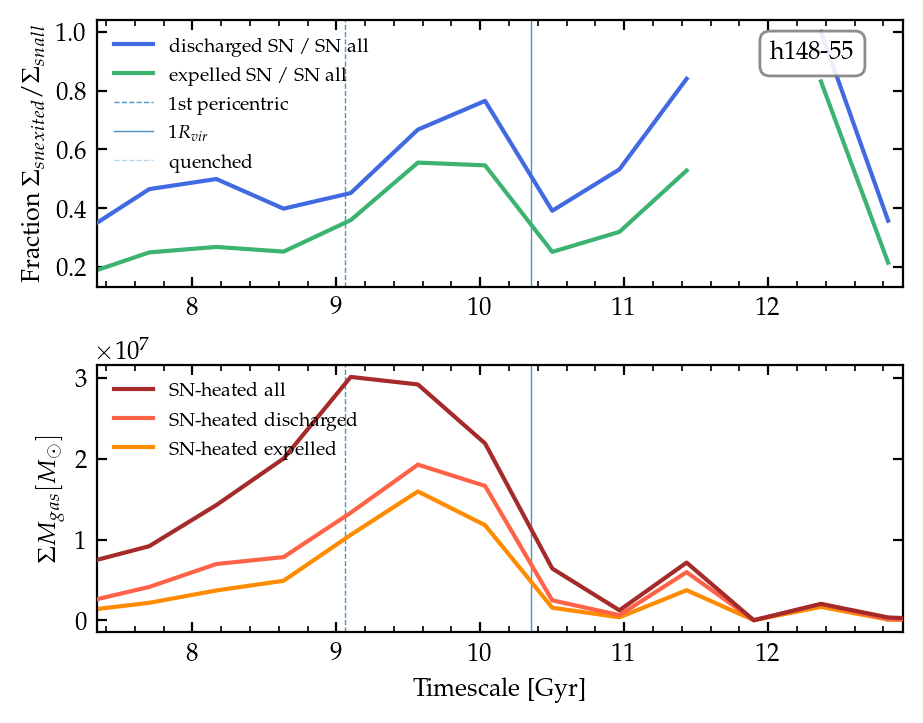

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_6 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


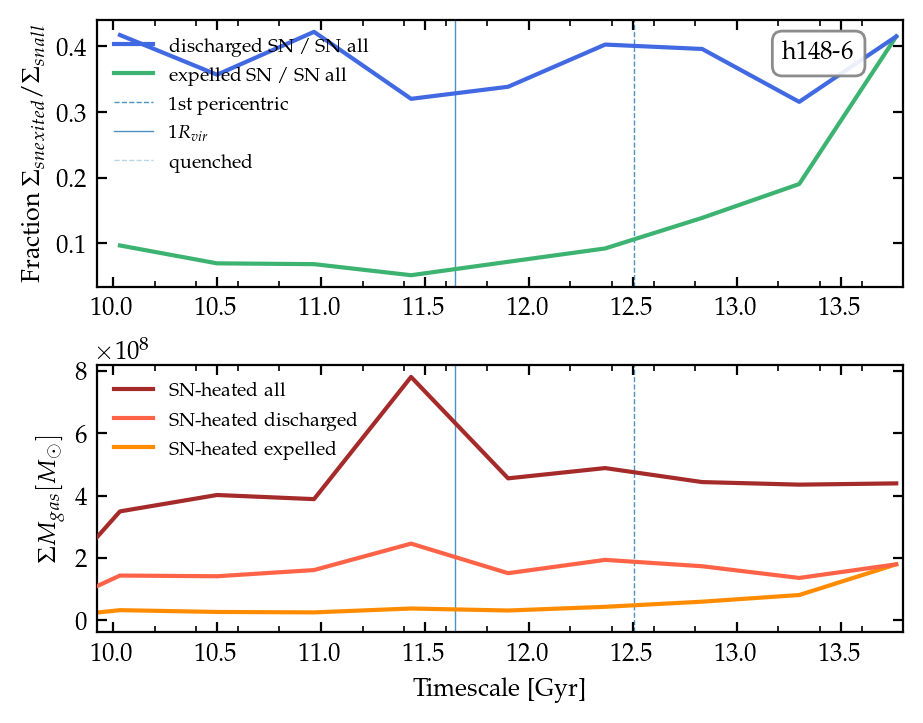

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_65 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


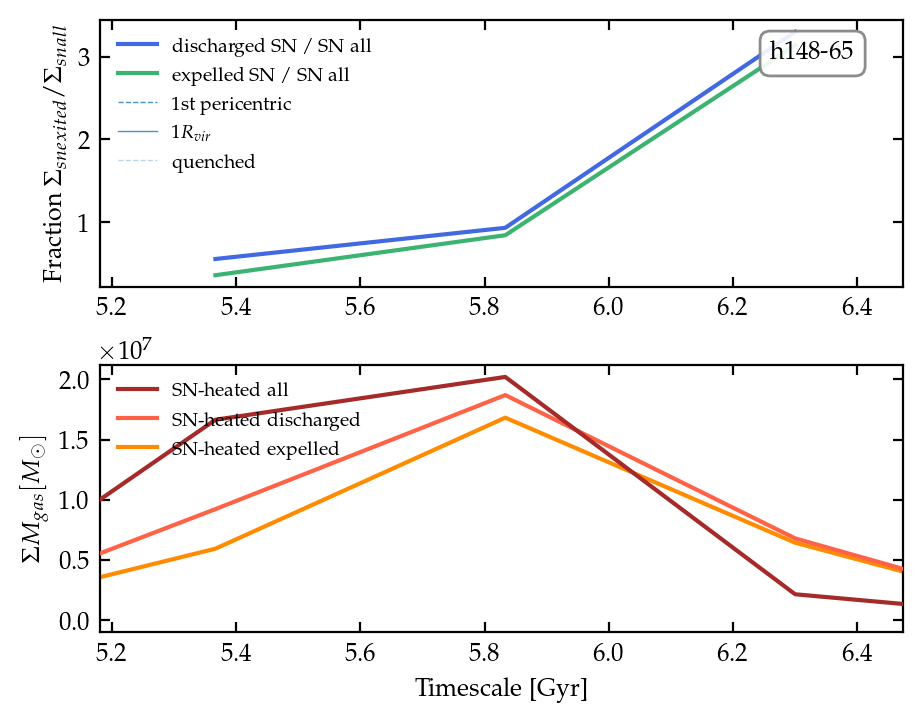

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_14 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


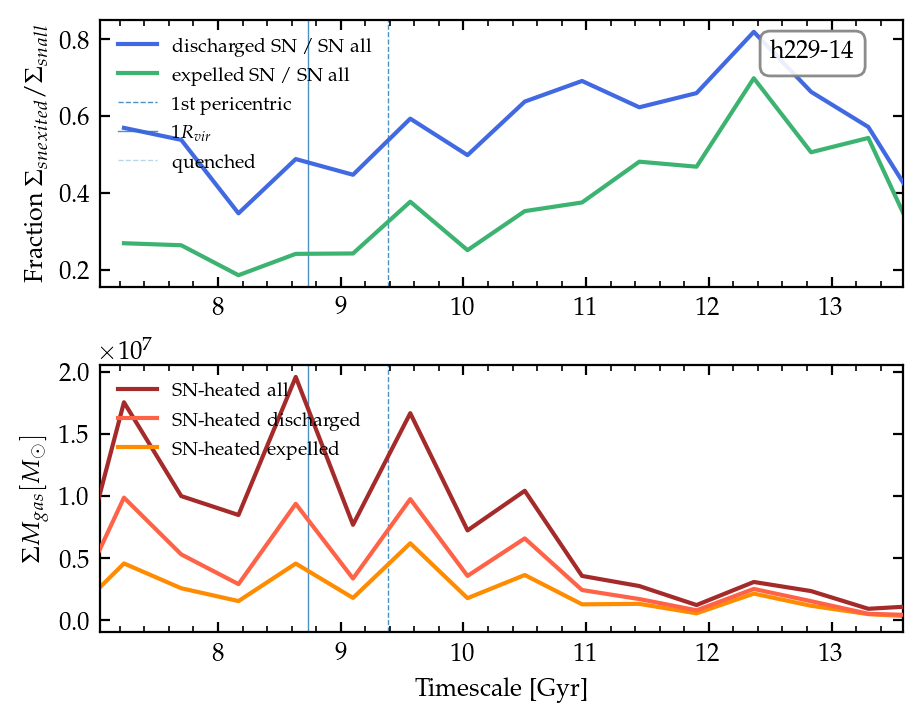

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_18 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


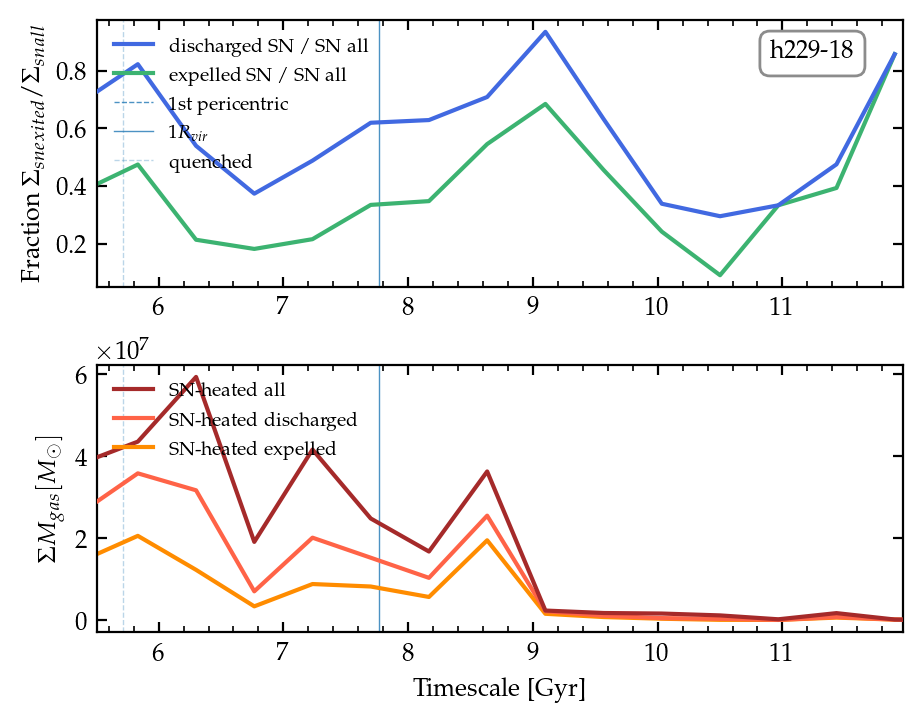

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_20 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


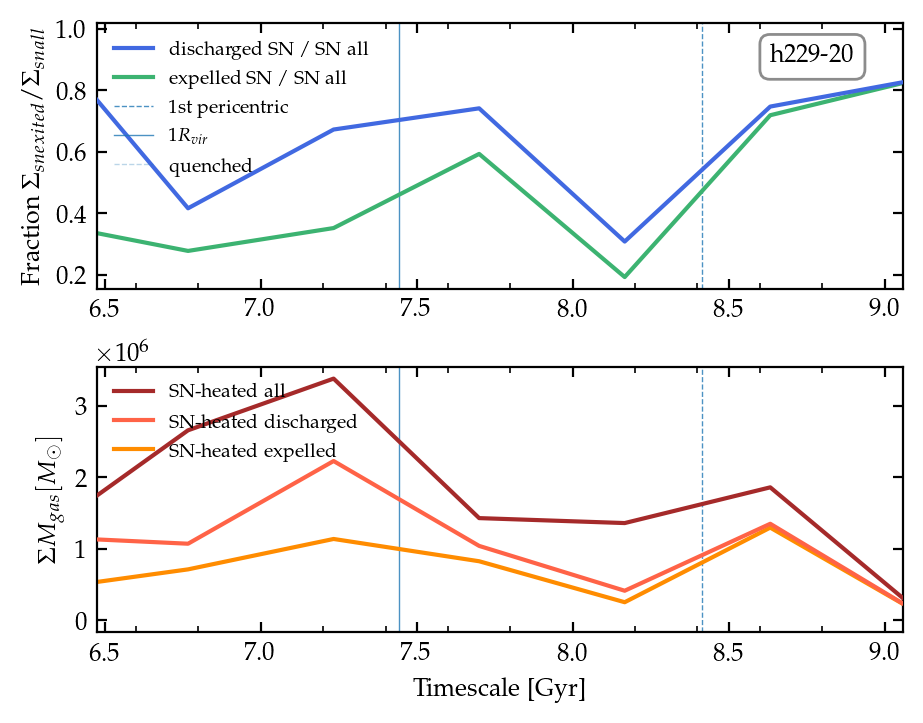

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_22 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


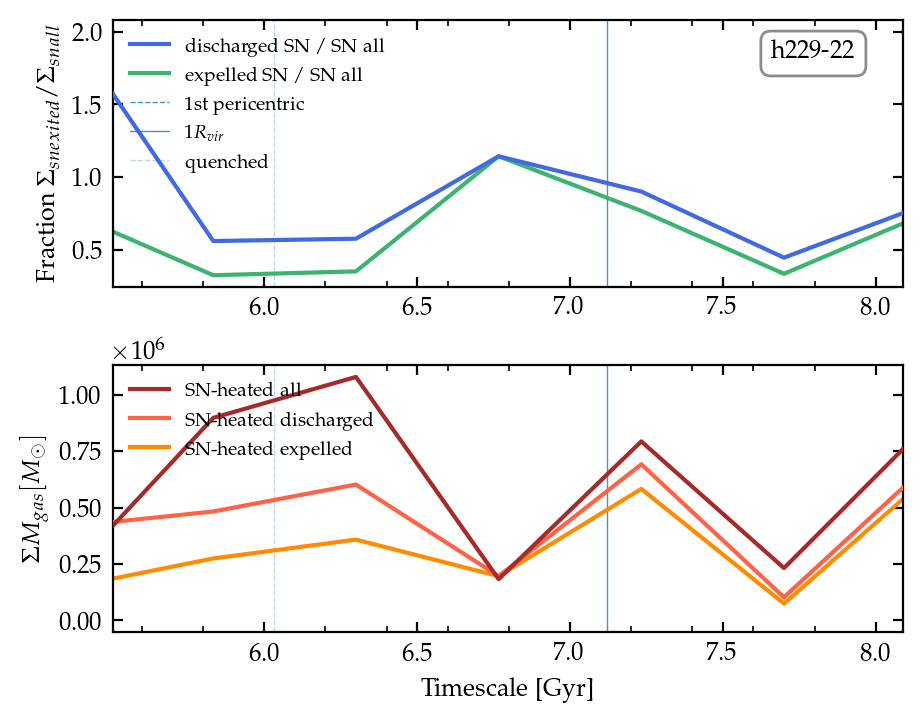

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_49 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


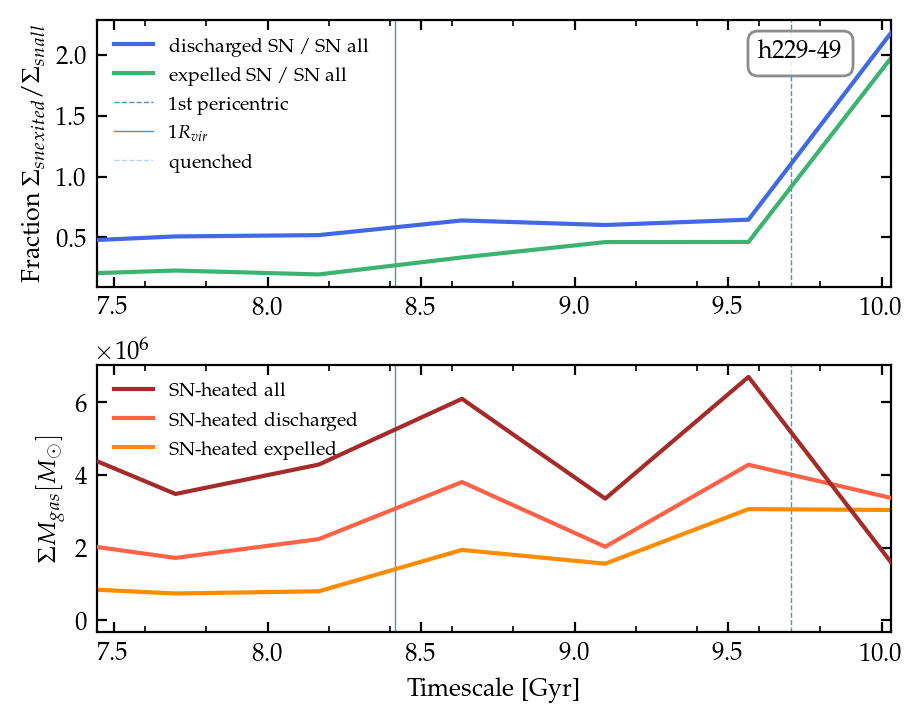

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_10 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


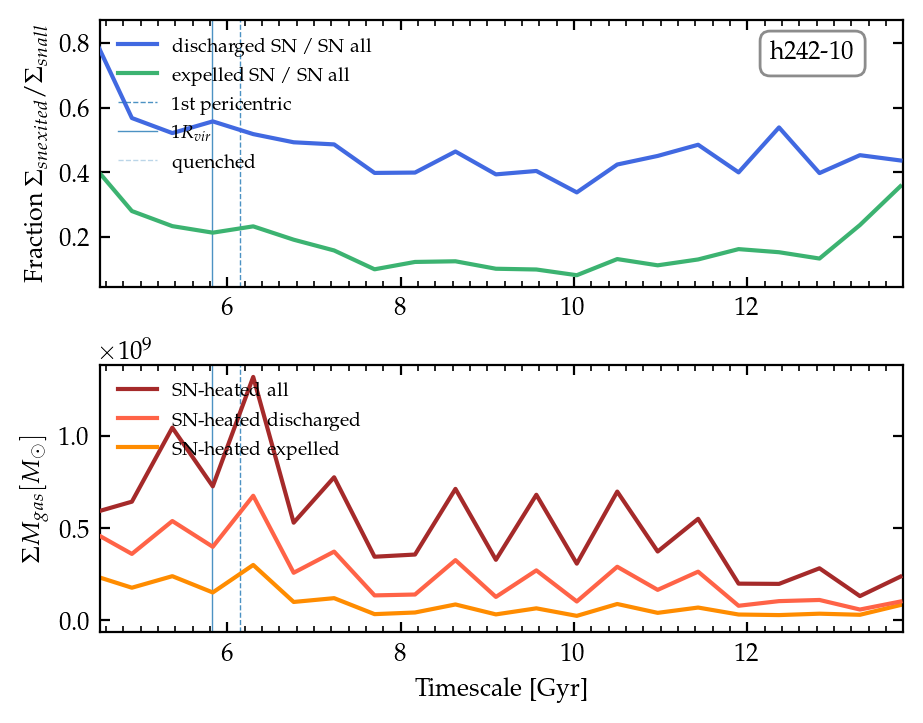

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_21 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


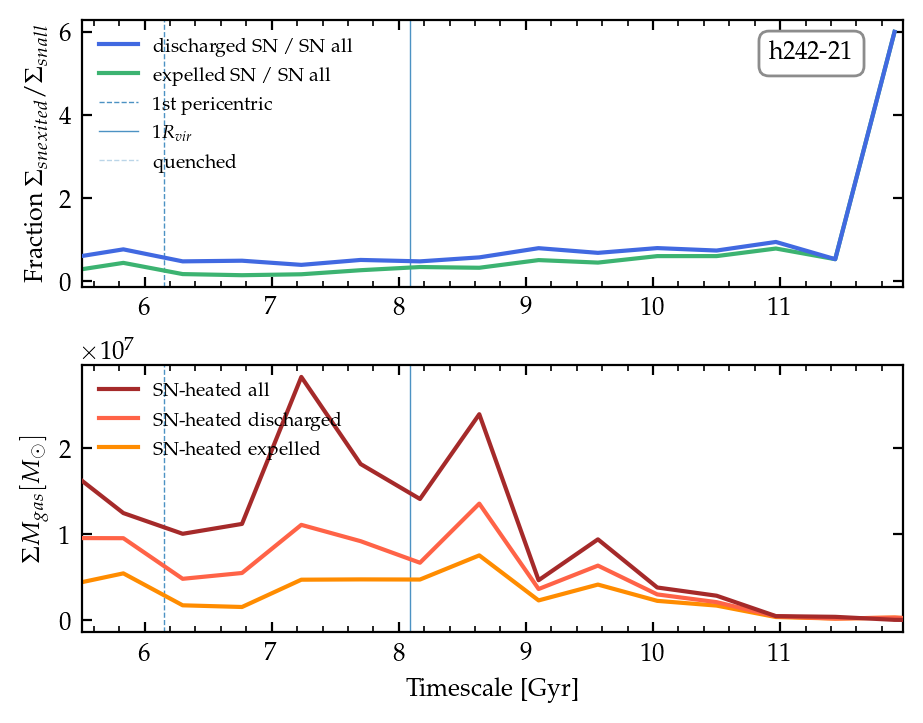

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_30 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


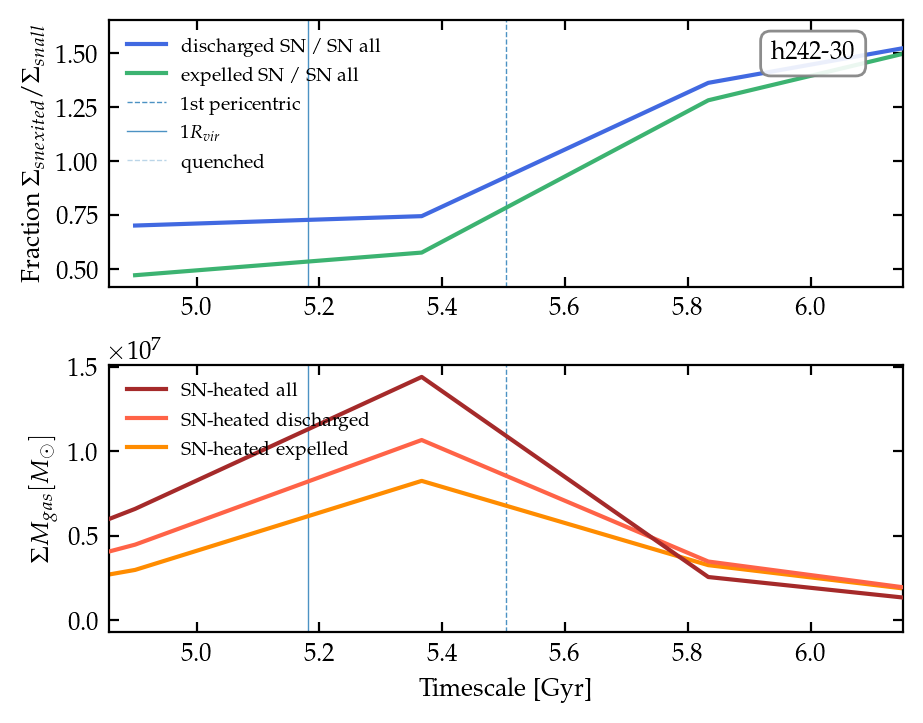

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_38 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


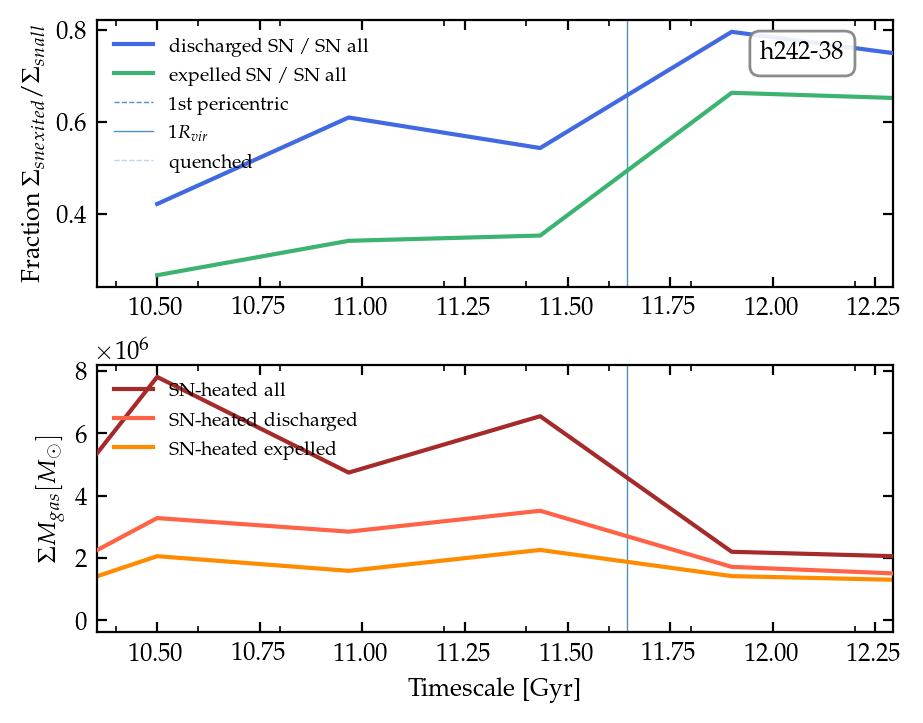

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_69 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


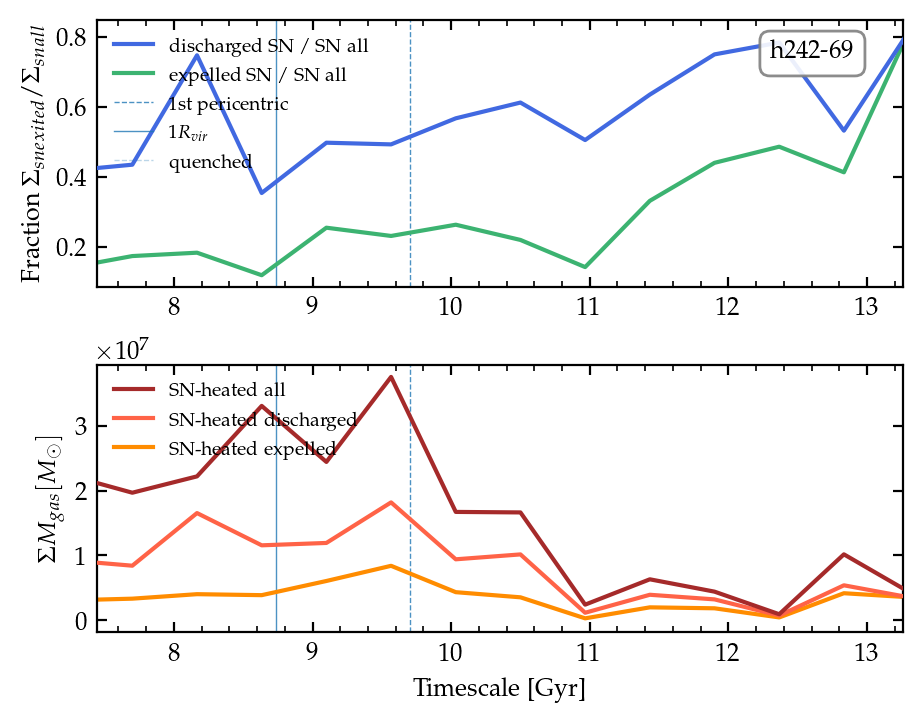

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_8 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


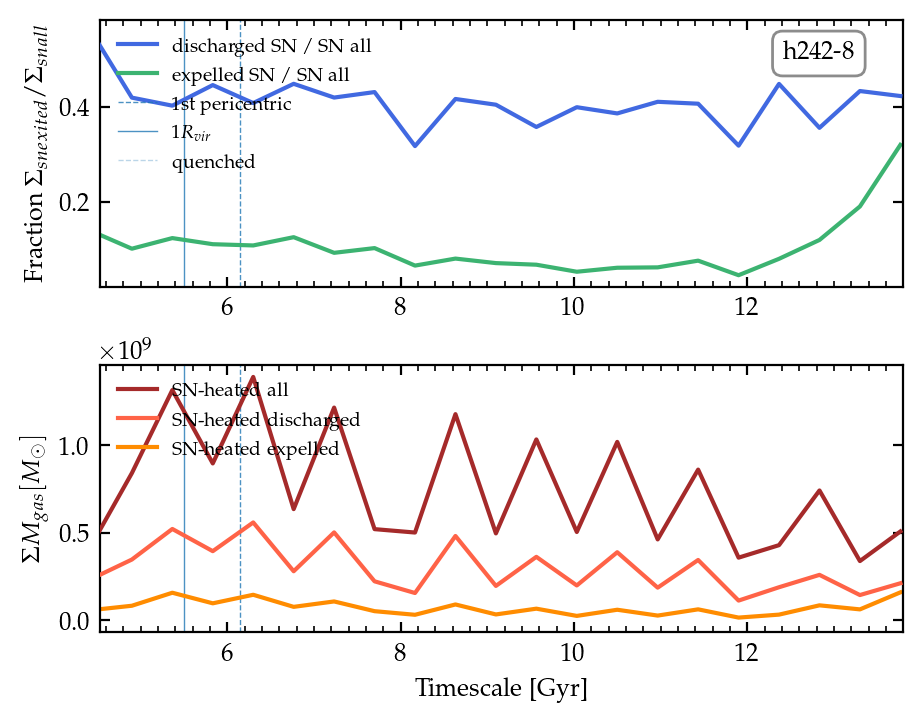

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_117 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


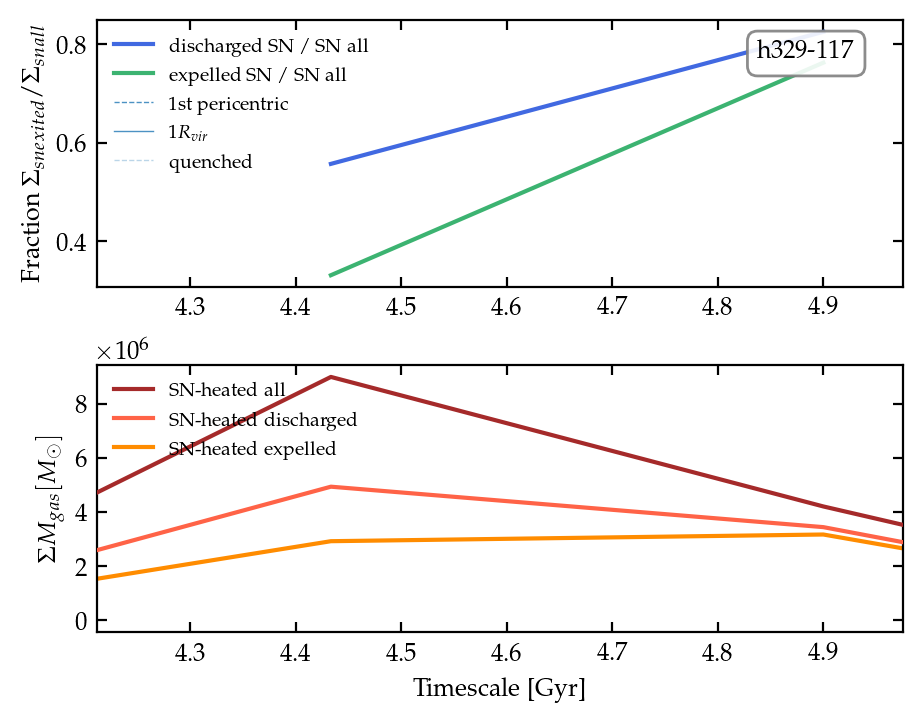

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_29 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


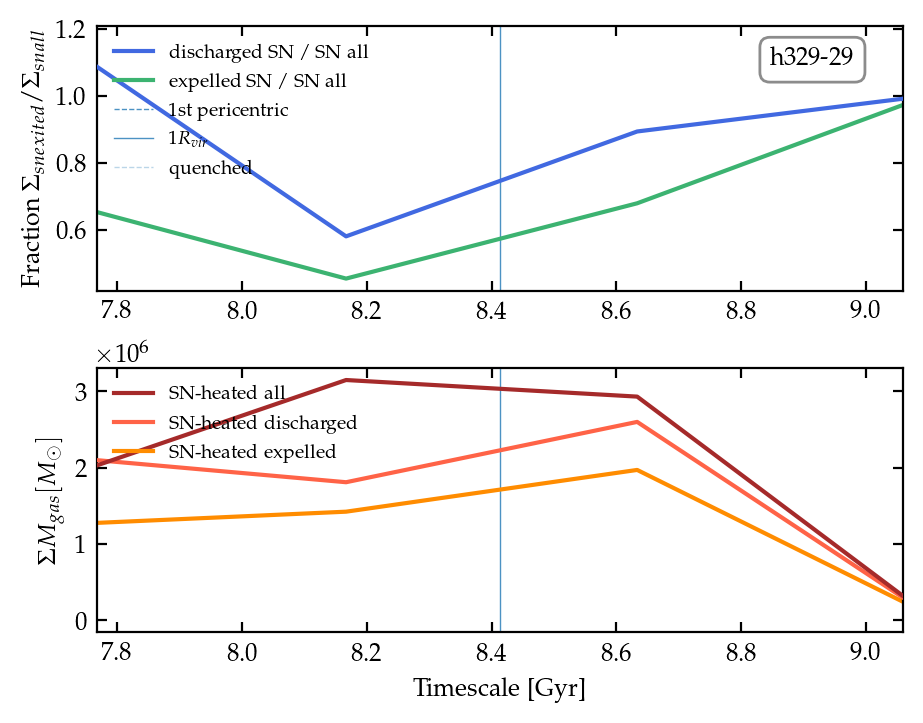

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_7 <


/tmp/ipykernel_31804/1469157511.py:46: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/1469157511.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


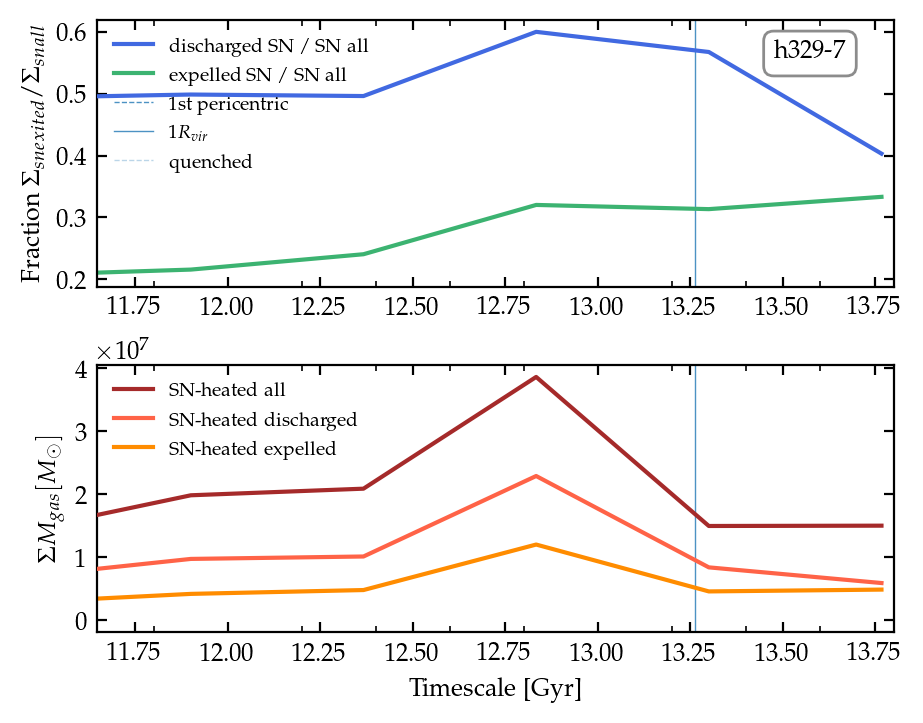

Program finished execution:  216.80213022232056  s


In [40]:
import time
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

start = time.time()
#load distance from host information
r_data = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/all-satellite-information-2.csv')
    
for key in keys:
    #run for all other satellites

    #load particles
    sim = str(key[:4])
    haloid = int(key[5:])
    particles = read_tracked_particles(sim, haloid)

    # all snheated gas, binned
    filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/heated_all_particles.hdf5'
    heated_all = pd.read_hdf(filepath, key=key)
    
    #fraction of discharged/heated
    bins = 30
    rangeMax = 14
    
    #bin
    snt, x = np.histogram(heated_all.time, bins=bins, range=(0,rangeMax))
    
    #discharged sn-heated gas, binned
    _, discharged = read_one_discharged(key)
    heated_dis = discharged[discharged['snHeated']==True].drop_duplicates(subset=['pid', 'time'])
    #bin
    dist, x = np.histogram(heated_dis.time, bins=bins, range=(0,rangeMax))

    #expelled sn-heated gas, binned
    _, expelled = read_one_expelled(key)
    heated_exp = expelled[expelled['snHeated']==True].drop_duplicates(subset=['pid', 'time'])
    #bin
    expt, x = np.histogram(heated_exp.time, bins=bins, range=(0,rangeMax))

    # computing fraction dist/snt
    fracDis = np.array([])
    fracExp = np.array([])

    for i in range(0, bins):
        ratioDis = dist[i]/snt[i]
        ratioExp = expt[i]/snt[i]
        fracDis = np.append(fracDis,ratioDis)
        fracExp = np.append(fracExp,ratioExp)
        i += 1


    fig, ax = plt.subplots(2,1,figsize = (4.5,3.5))
    # fraction sne/all:
    bincenters = 0.5*(x[1:] + x[:-1])
    ax[0].plot(bincenters, fracDis, c = 'royalblue', label='discharged SN / SN all', zorder = 3)
    ax[0].plot(bincenters, fracExp, c = 'mediumseagreen', label='expelled SN / SN all', zorder = 2)
    ax[0].set_ylabel('Fraction $\Sigma_{sn exited} / \Sigma_{sn all}$')
    ax[0].set_xlim(np.min(heated_all.time), np.max(heated_all.time))
    ax[0].tick_params(direction='in',which='both',right=True,top=True)

    
    # mass distributions:
    # all snheated gas
    snall, x = np.histogram(heated_all.time, bins=bins, weights=heated_all.mass, range=(0,rangeMax))
    snexpelled, x = np.histogram(heated_exp.time, bins=bins, weights=heated_exp.mass, range=(0,rangeMax))
    sndischarged, x = np.histogram(heated_dis.time, bins=bins, weights=heated_dis.mass, range=(0,rangeMax))

    bincenters = 0.5*(x[1:] + x[:-1])
    ax[1].plot(bincenters, snall, label='SN-heated all', c='brown', zorder = 4)
    ax[1].plot(bincenters, sndischarged, label='SN-heated discharged', c='tomato', zorder = 3)
    ax[1].plot(bincenters, snexpelled, label='SN-heated expelled', c='darkorange', zorder = 2)
    ax[1].set_xlim(np.min(heated_all.time), np.max(heated_all.time))
    ax[1].set_xlabel('Timescale [Gyr]')
    ax[1].set_ylabel('$\Sigma M_{gas} [M_{\odot}]$')
    
    
    #show where it reaches 1 Rvir distant from host, and where it hits the 1st pericentric distance
    r_data_read = r_data[(r_data.sim==sim)&(r_data.haloid==haloid)]
    p_time = float(r_data_read['1st p_time'])
    vir_time = float(r_data_read['t_1Rvir_from_Host'])
    q_time = float(r_data_read['tquench'])
    
    #make a vertical line indicating those instances
    ax[0].axvline(x=p_time, linestyle='dashed', label='1st pericentric', 
                 alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax[1].axvline(x=p_time, linestyle='dashed', alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax[0].axvline(x=vir_time, linestyle='solid', label='$1 R_{vir}$', 
                 alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax[1].axvline(x=vir_time, linestyle='solid', alpha = 0.8, linewidth = 0.5, zorder = 1)
    if not q_time == np.nan: #it's quenched
        ax[0].axvline(x=q_time, linestyle='dashed', label='quenched', 
                     alpha = 0.3, linewidth = 0.5, zorder = 1)
        ax[1].axvline(x=q_time, linestyle='dashed', alpha = 0.3, linewidth = 0.5, zorder = 1)
      
    ax[0].legend(fontsize=7,loc='upper left')
    ax[1].legend(fontsize=7,loc='upper left')
    ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    ax[0].annotate(f"{key.replace('_','-')}", (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)
    ax[1].tick_params(direction='in',which='both',right=True,top=True)
    ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    
    #save
    plt.savefig(f'plots/{key}_fracSN_NEW.pdf')
    plt.show()

end = time.time()
print("Program finished execution: ", end - start, " s") #took 322s

I still have fraction above 1 for some small satellites with smaller fraction of SN-heated gas, but we can sort of see the trend that the fraction of gas loss is bigger after 1 Rvir than before. For quenched galaxy (or smaller galaxy), due to its less sample size, I ended up having the weird fraction overall and need further analysis on accurately calculating the fraction.

### Calculate avg fracSN before and after 1 Rvir from host, and around 1st pericenter
Some of the code inside the function is repetitive (same as above), just because I didn't save the fracSN.
But it computes very fast so I wouldn't mind re-binning those.

Later I plotted the fraction of SN-heated gas that is lost at different times in infall. We should note that those fractions happen to exceed 1.

In [46]:
def calc_avg_fracSN(key, save=True):
    import os
    output = pd.DataFrame()
    
    #load satellite information
    data = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/all-satellite-information-2.csv')
    sim = str(key[:4])
    haloid = int(key[5:])
    data_local = data[(data.sim==sim)&(data.haloid==haloid)]
    output = pd.concat([output, data_local])
    
    ### Recalculating fracSN ###
    #fraction of discharged/heated
    bins = 30
    rangeMax = 14
    
    # all snheated gas, binned
    filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/heated_all_particles.hdf5'
    heated_all = pd.read_hdf(filepath,key=key)
    #bin
    snt, x = np.histogram(heated_all.time, bins=bins, range=(0,rangeMax))
    
    #discharged sn-heated gas, binned
    _, discharged = read_one_discharged(key)
    heated_dis = discharged[discharged['snHeated']==True].drop_duplicates(subset=['pid', 'time'])
    #bin
    dist, x = np.histogram(heated_dis.time, bins=bins, range=(0,rangeMax))

    #expelled sn-heated gas, binned
    _, expelled = read_one_expelled(key)
    heated_exp = expelled[expelled['snHeated']==True].drop_duplicates(subset=['pid', 'time'])
    #bin
    expt, x = np.histogram(heated_exp.time, bins=bins, range=(0,rangeMax))

    #computing fraction dist/snt
    fracDis = np.array([])
    fracExp = np.array([])

    for i in range(0, bins):
        ratioDis = dist[i]/snt[i]
        ratioExp = expt[i]/snt[i]
        fracDis = np.append(fracDis,ratioDis)
        fracExp = np.append(fracExp,ratioExp)
        i += 1
        
    #time array
    bincenters = 0.5*(x[1:] + x[:-1])
    ### Recalculation end here ###
    
    
    if ~np.isnan(float(data_local.t_1Rvir_from_Host)):
        #time at infalling into 1 Rvir from host
        tRvir = float(data_local['t_1Rvir_from_Host'])
        
        #calculate avg fracSN before and after tRvir 
        """
        Reason to cut the last 1 Gyr is because there is a significant increase in fracExp for all satellites.
        To avoid being confused about averaging before and after the last 1 Gyr increase, 
        here intentionally cut the last 1 Gyr when calculating post tRvir. (discussed on 7/27/23)
        """
        fracDis_Rvir_after = fracDis[np.where((bincenters > tRvir)&(bincenters < 13))[0]]        
        fracDis_Rvir_before = fracDis[np.where(bincenters < tRvir)[0]]
        #remove NaN of infinite if any
        fracDis_Rvir_after = fracDis_Rvir_after[np.isfinite(fracDis_Rvir_after)]
        fracDis_Rvir_before = fracDis_Rvir_before[np.isfinite(fracDis_Rvir_before)]
        
        fracExp_Rvir_after = fracExp[np.where((bincenters > tRvir)&(bincenters < 13))[0]]        
        fracExp_Rvir_before = fracExp[np.where(bincenters < tRvir)[0]]
        #remove NaN of infinite if any
        fracExp_Rvir_after = fracExp_Rvir_after[np.isfinite(fracExp_Rvir_after)]
        fracExp_Rvir_before = fracExp_Rvir_before[np.isfinite(fracExp_Rvir_before)]
        
        #append avg values
        output['fracDis_Rvir_after'] = np.mean(fracDis_Rvir_after)
        output['fracDis_Rvir_before'] = np.mean(fracDis_Rvir_before)
        output['fracExp_Rvir_after'] = np.mean(fracExp_Rvir_after)
        output['fracExp_Rvir_before'] = np.mean(fracExp_Rvir_before)
      
    else:
        print(f'Couldnt find t_1Rvir_from_Host value for {key}')
        output['fracDis_Rvir_after'] = np.nan
        output['fracDis_Rvir_before'] = np.nan
        output['fracExp_Rvir_after'] = np.nan
        output['fracExp_Rvir_before'] = np.nan
    
    
    if ~np.isnan(float(data_local['1st p_time'])):
        tpericenter = float(data_local['1st p_time'])
        #calculate avg fracSN around 1st pericentric passage (within 1 Gyr)
        fracDis_pericenter = fracDis[np.where(np.isclose(bincenters, tpericenter, atol = 0.5))[0]]        
        fracExp_pericenter = fracExp[np.where(np.isclose(bincenters, tpericenter, atol = 0.5))[0]]
        #remove NaN of infinite if any
        fracDis_pericenter = fracDis_pericenter[np.isfinite(fracDis_pericenter)]
        fracExp_pericenter = fracExp_pericenter[np.isfinite(fracExp_pericenter)]
        
        #append avg values
        output['fracDis_pericenter'] = np.mean(fracDis_pericenter)
        output['fracExp_pericenter'] = np.mean(fracExp_pericenter)

    else:
        print(f'Couldnt find 1st p_time for {key}')
        output['fracDis_pericenter'] = np.nan
        output['fracExp_pericenter'] = np.nan
        
        
    #save the output (also avoid duplicates)    
    if save:
        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_fracSN_calculation_NEW.csv'
        
        if os.path.exists(filepath):
            output.to_csv(filepath, mode='a', index = False, header = False)
        
        else:
            #create a file with the appropriate header
            output.to_csv(filepath, index = False)
        
        #print(f'Saving {key} avg fracSN values to {filepath}')

    return output

In [47]:
#run calc_avg_fracSN for all satellites
import time
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

start = time.time()

for key in keys:
    output = calc_avg_fracSN(key)
    
end = time.time()
print("Program finished execution: ", end - start, " s") #31s

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_2 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_249 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_251 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_27 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: R

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_282 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_3 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_34 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_38 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_4 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_55 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_6 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: R

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_65 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_14 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h229_18 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_20 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h229_22 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h229_49 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h242_10 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h242_21 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_30 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h242_38 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_69 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h242_8 <


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: R

> Returning (predischarged, discharged, hot_predischarged) for satellite h329_117 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_29 <
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_7 <
Program finished execution:  13.928563356399536  s


/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:40: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_31804/3467840156.py:41: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/watanabe/anaconda3/envs/conda-env-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: R

In [48]:
output = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_fracSN_calculation_NEW.csv')
output

,haloid,quenched,tquench,tquench_lower,tquench_upper,tinfall,tinfall_lower,tinfall_upper,M_star,sim,...,sSFRquench,sSFRpericenter,1Rvir_from_Host,t_1Rvir_from_Host,fracDis_Rvir_after,fracDis_Rvir_before,fracExp_Rvir_after,fracExp_Rvir_before,fracDis_pericenter,fracExp_pericenter
0,10,False,NaN,NaN,NaN,5.602745,5.602745,5.602745,1.353274e+08,h148,...,NaN,1.071027e-10,1.106245,7.767072,0.381646,0.308634,0.084738,0.012831,0.437834,0.087181
1,12,True,4.740687,5.191869,-0.000097,5.602745,5.602745,5.602745,1.043767e+08,h148,...,NaN,1.746652e-11,1.058444,9.490994,0.536577,0.515892,0.386262,0.313844,0.594117,0.417361
2,2,False,NaN,NaN,NaN,0.861961,1.292941,0.861961,2.268773e+09,h148,...,NaN,1.826039e-10,1.034413,12.507856,0.359147,0.346056,0.126639,0.047039,0.284328,0.284328
3,249,True,3.878726,3.878726,3.878726,5.602745,5.602745,5.191967,2.063790e+06,h148,...,NaN,5.584402e-11,0.995560,8.198053,0.821942,0.420265,0.736679,0.198287,0.685548,0.647527
4,251,True,6.464608,6.464608,6.464608,6.895686,6.895686,6.895686,2.149496e+06,h148,...,0.000000e+00,1.710476e-10,0.879712,6.905111,0.638132,0.548980,0.583658,0.343064,0.638132,0.583658
5,27,True,1.649749,1.649749,-0.000097,7.326666,7.326666,7.326666,8.415728e+07,h148,...,NaN,1.636955e-10,0.846832,6.474131,0.574585,0.448314,0.313672,0.197549,0.547914,0.269516
6,282,True,10.067335,10.067335,10.067335,9.481568,9.481568,9.481568,3.984286e+06,h148,...,NaN,3.222737e-11,0.922127,5.181190,NaN,0.876116,NaN,0.807828,1.018719,0.980517
7,3,False,NaN,NaN,NaN,3.878823,4.309804,3.878823,1.502171e+09,h148,...,NaN,8.215728e-11,1.034948,9.490994,0.329266,0.369129,0.072086,0.048440,0.308552,0.062327
8,34,True,0.430883,0.430883,0.430883,4.740784,4.740784,4.309804,5.759679e+06,h148,...,NaN,1.041171e-10,0.972199,9.060013,1.509761,0.394469,0.870180,0.186052,0.509895,0.336195
9,38,True,4.309706,4.309706,4.309706,6.033725,6.033725,6.033725,1.374093e+07,h148,...,NaN,3.722322e-11,1.153086,7.336092,0.693991,0.509549,0.509328,0.246584,0.668831,0.447149


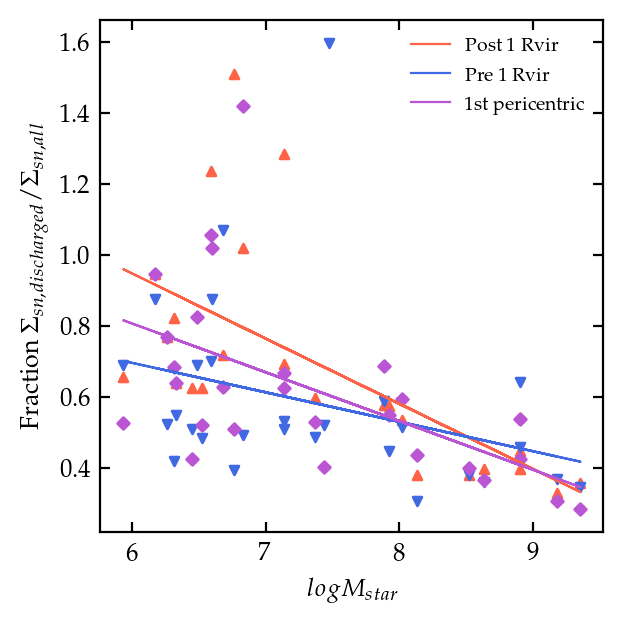

In [49]:
#plot avg fracSN over log stellar mass, and make a linear fit
#fracDis first
output = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/avg_fracSN_calculation_NEW.csv')

fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

# first, log-convert the data:
from scipy.optimize import curve_fit
def func(x,s,y0):
    return y0+s*x

# the initial guess for the function parameters:
s_guess = [1]
y_guess = [3]

#'fracDis_Rvir_after'
xa = np.log10(output['M_star'][np.isfinite(output['fracDis_Rvir_after'])])
ya = output['fracDis_Rvir_after'][np.isfinite(output['fracDis_Rvir_after'])]
plt.scatter(np.log10(output['M_star']), output['fracDis_Rvir_after'], c='tomato', marker = "^", s = 10)

popt, pcov = curve_fit(func, xa, ya, p0=[s_guess,y_guess])
plt.plot(xa, func(xa, *popt), lw = 0.8, c='tomato', label = 'Post 1 Rvir')

#'fracDis_Rvir_before'
xb = np.log10(output['M_star'][np.isfinite(output['fracDis_Rvir_before'])])
yb = output['fracDis_Rvir_before'][np.isfinite(output['fracDis_Rvir_before'])]
plt.scatter(np.log10(output['M_star']), output['fracDis_Rvir_before'], c='royalblue', marker = "v", s = 10)

popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
plt.plot(xb, func(xb, *popt), lw = 0.8, c='royalblue', label = 'Pre 1 Rvir')

#'fracDis_pericenter'
xp = np.log10(output['M_star'][np.isfinite(output['fracDis_pericenter'])])
yp = output['fracDis_pericenter'][np.isfinite(output['fracDis_pericenter'])]
plt.scatter(np.log10(output['M_star']), output['fracDis_pericenter'], c='mediumorchid', marker = "D", s = 9)

popt, pcov = curve_fit(func, xp, yp, p0=[s_guess,y_guess])
plt.plot(xp, func(xp, *popt), lw = 0.8, c='mediumorchid', label = '1st pericentric')

ax.set_xlabel("$log M_{star}$")
ax.set_ylabel('Fraction $\Sigma_{sn, discharged} / \Sigma_{sn, all}$')
plt.legend(fontsize = 7)
#save
plt.savefig(f'plots/avg_fracDis_NEW.pdf')
plt.show()

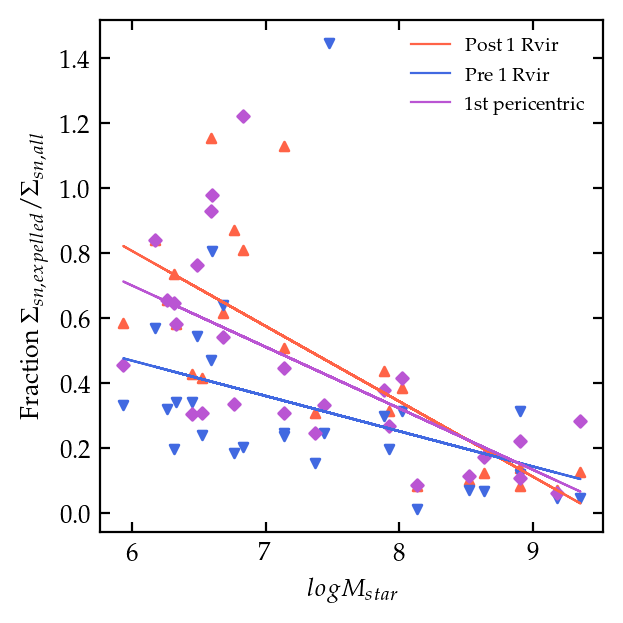

In [50]:
#fracExp
fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

#'fracExp_Rvir_after'
xa = np.log10(output['M_star'][np.isfinite(output['fracExp_Rvir_after'])])
ya = output['fracExp_Rvir_after'][np.isfinite(output['fracExp_Rvir_after'])]
plt.scatter(np.log10(output['M_star']), output['fracExp_Rvir_after'], c='tomato', marker = "^", s = 10)

popt, pcov = curve_fit(func, xa, ya, p0=[s_guess,y_guess])
plt.plot(xa, func(xa, *popt), lw = 0.8, c='tomato', label = 'Post 1 Rvir')

#'fracExp_Rvir_before'
xb = np.log10(output['M_star'][np.isfinite(output['fracExp_Rvir_before'])])
yb = output['fracExp_Rvir_before'][np.isfinite(output['fracExp_Rvir_before'])]
plt.scatter(np.log10(output['M_star']), output['fracExp_Rvir_before'], c='royalblue', marker = "v", s = 10)

popt, pcov = curve_fit(func, xb, yb, p0=[s_guess,y_guess])
plt.plot(xb, func(xb, *popt), lw = 0.8, c='royalblue', label = 'Pre 1 Rvir')

#'fracExp_pericenter'
xp = np.log10(output['M_star'][np.isfinite(output['fracExp_pericenter'])])
yp = output['fracExp_pericenter'][np.isfinite(output['fracExp_pericenter'])]
plt.scatter(np.log10(output['M_star']), output['fracExp_pericenter'], c = 'mediumorchid', marker = "D", s = 9)

popt, pcov = curve_fit(func, xp, yp, p0=[s_guess,y_guess])
plt.plot(xp, func(xp, *popt), lw = 0.8, c = 'mediumorchid', label = '1st pericentric')

ax.set_xlabel("$log M_{star}$")
ax.set_ylabel('Fraction $\Sigma_{sn, expelled} / \Sigma_{sn, all}$')
plt.legend(fontsize = 7)
#save
#plt.savefig(f'plots/avg_fracExp_NEW.pdf')
plt.show()

Seems like ram pressure boosting sn-heated particles to discharged/expell. For both discharged and expelled gas, 1st pericenter in orange is higher than post 1 Rvir, indicating that at the closest point in infalling, more sn-heated gas is being discharged or expelled. This trend is more apperent in smaller mass size of the galaxies, which is more vulnerable to environmental factors. (Weitz et al., 2015) Interestingly, this 'boosting' is more significant in expelling the gas rather than discharging the gas, since 1st pericenter is higher than pre 1 Rvir in expelled gas, whereas for discharged gas pre 1 Rvir is slightly higher but no big difference. This proves the theory that ram pressure is more effective in expelling the gas rather than discharging the gas that are heated by supernovae. (for $\log M_{star} < 10^9$)

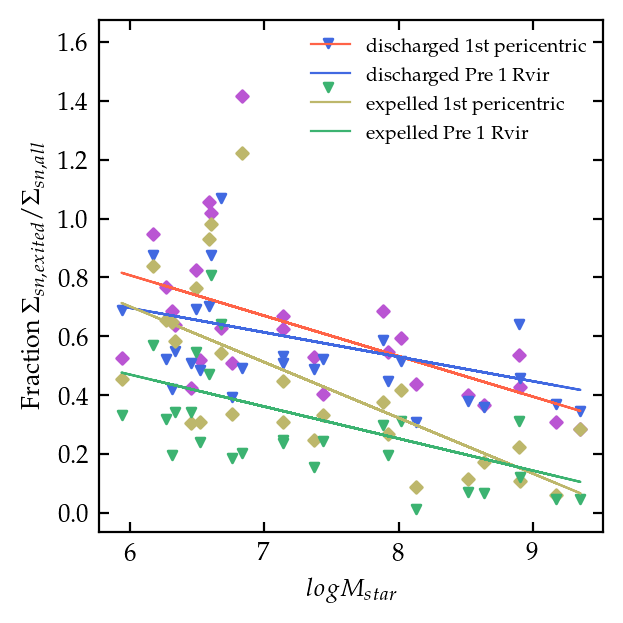

In [51]:
#comparing pre and post 1 Rvir for expelled and discharged gas together
fig, ax = plt.subplots(1,1, dpi=200, figsize = (3,3))

#'fracDis_pericenter'
xp1 = np.log10(output['M_star'][np.isfinite(output['fracDis_pericenter'])])
yp1 = output['fracDis_pericenter'][np.isfinite(output['fracDis_pericenter'])]
plt.scatter(np.log10(output['M_star']), output['fracDis_pericenter'], c = 'mediumorchid', marker = "D", s = 9)

popt, pcov = curve_fit(func, xp1, yp1, p0=[s_guess,y_guess])
plt.plot(xp1, func(xp1, *popt), lw = 0.8, c = 'tomato', label = 'discharged 1st pericentric')

#'fracDis_Rvir_before'
xb1 = np.log10(output['M_star'][np.isfinite(output['fracDis_Rvir_before'])])
yb1 = output['fracDis_Rvir_before'][np.isfinite(output['fracDis_Rvir_before'])]
plt.scatter(np.log10(output['M_star']), output['fracDis_Rvir_before'], c = 'royalblue', marker = "v", s = 10)

popt, pcov = curve_fit(func, xb1, yb1, p0=[s_guess,y_guess])
plt.plot(xb1, func(xb1, *popt), lw = 0.8, c = 'royalblue', label = 'discharged Pre 1 Rvir')

#'fracExp_pericenter'
xp2 = np.log10(output['M_star'][np.isfinite(output['fracExp_pericenter'])])
yp2 = output['fracExp_pericenter'][np.isfinite(output['fracExp_pericenter'])]
plt.scatter(np.log10(output['M_star']), output['fracExp_pericenter'], c = 'darkkhaki', marker = "D", s = 9)

popt, pcov = curve_fit(func, xp2, yp2, p0=[s_guess,y_guess])
plt.plot(xp2, func(xp2, *popt), lw = 0.8, c = 'darkkhaki', label = 'expelled 1st pericentric')

#'fracExp_Rvir_before'
xb2 = np.log10(output['M_star'][np.isfinite(output['fracExp_Rvir_before'])])
yb2 = output['fracExp_Rvir_before'][np.isfinite(output['fracExp_Rvir_before'])]
plt.scatter(np.log10(output['M_star']), output['fracExp_Rvir_before'], c = 'mediumseagreen', marker = "v", s = 10)

popt, pcov = curve_fit(func, xb2, yb2, p0=[s_guess,y_guess])
plt.plot(xb2, func(xb2, *popt), lw = 0.8, c = 'mediumseagreen', label = 'expelled Pre 1 Rvir')

ax.set_xlabel("$log M_{star}$")
ax.set_ylabel('Fraction $\Sigma_{sn, exited} / \Sigma_{sn, all}$')
plt.legend(fontsize = 7)
#save
plt.savefig(f'plots/avg_fracSN_pericentric_NEW.pdf')
plt.show()

### Miscellaneous
Below are my codes used for brainstorming how to calculate sn-heated all particles. Definition of calculating snheated all gas, named ```calc_snHeated(sim, haloid, save=True)``` is also declared below. (Also defined under ```dischargedgastracking.py```)

In [258]:
len(heated_dis)

69870

In [47]:
Counter(discharged.pid)

Counter({936805: 1,
         1336093: 2,
         1352518: 1,
         2173227: 2,
         2235729: 3,
         2317970: 3,
         2602227: 2,
         2617848: 2,
         2633295: 1,
         2641844: 2,
         2642651: 1,
         2666892: 3,
         2668564: 1,
         2691146: 1,
         2709586: 1,
         2713926: 3,
         2719821: 3,
         2783370: 3,
         2784669: 2,
         2785629: 2,
         2861255: 2,
         2939528: 3,
         3086130: 2,
         3093134: 2,
         3096408: 1,
         3099954: 2,
         3102716: 1,
         3108906: 1,
         3110702: 2,
         3111024: 1,
         3117486: 3,
         3117659: 2,
         3118321: 1,
         3125123: 1,
         3125339: 2,
         3126992: 2,
         3183198: 2,
         3380109: 1,
         3380123: 2,
         3854031: 1,
         3870572: 1,
         3877532: 1,
         3889067: 3,
         4040705: 1,
         4112916: 1,
         4135434: 1,
         4313141: 1,
         43154

In [115]:
discharged[((discharged.pid==8901053)|(discharged.pid==6933165))&(discharged.snHeated==True)]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
1254056,11.645896,6933165,0.028416,10590.229492,26986.935784,11.219633,2.850509,0.060595,-0.714163,-1.214831,...,21.124828,False,True,False,False,False,False,1.315466e+10,120.219597,True
986995,10.767100,8901053,0.067336,10033.865234,26806.649788,10.483096,5.164755,0.110537,3.296754,2.243037,...,19.057034,False,True,False,False,False,False,1.409881e+10,131.587268,True
1344540,12.076876,8901053,0.026048,10015.593750,27136.101067,11.674182,3.054410,0.064466,1.718132,-1.186382,...,19.769437,False,True,False,False,False,False,1.292568e+10,105.793418,True
1611008,12.938837,8901053,0.033036,9579.974609,27412.274096,12.907493,4.006311,0.084324,0.034498,0.911621,...,17.456248,False,True,False,False,False,False,1.215825e+10,121.618073,True


In [118]:
np.unique(np.diff(test.time))

array([0.        , 0.01683517, 0.07407475, 0.13468137, 0.29629901,
       0.35690563, 0.41077818, 0.41414521, 0.43098038, 0.43098038,
       0.43098038, 0.43098038, 0.43098038, 0.43098038, 0.43098038,
       0.43098038, 0.43098038, 0.43098038, 0.45118259])

In [119]:
particles[2:4]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
2,6.474131,639135,0.000019,42154.210938,26510.536704,0.0,743.057345,20.242159,32.164885,-611.435712,...,0.43098,0.913015,19.59562,False,False,False,False,False,True,1.417260e+10
3,6.474131,690707,0.000167,93560.257812,26510.536704,0.0,669.160153,18.229072,66.143066,-372.504420,...,0.43098,0.913015,19.59562,False,False,False,False,False,True,1.417260e+10


In [238]:
# particles = read_tracked_particles('h148', 10)
test = particles[(particles.pid==8901053) | (particles.pid==6933165)]
dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
testarray=np.array(list(zip(test.index, *map(test.get, ['pid','time','coolontime']))), dtype=dtype)
#print(testarray)
testarray=testarray[testarray['time']>testarray['coolontime']]
helper1, helper2 = np.unique(testarray['coolontime'], return_index = True)
testunique = np.sort(testarray[helper2], order=['pid','time'])
print(testunique)
pids = np.unique(testunique['pid'])
index = np.array([])
for pid in pids:
    dat = testunique[testunique['pid']==pid]
    timebefore = dat['time'][:-1]
    heatedArray = dat[1:][dat['coolontime'][1:]>timebefore]
    heatedIndex = heatedArray['index'].astype(int)
    index = np.append(index, heatedIndex)
heated = test[test.index.isin(index)]    

[(    826, 6933165,  6.47413103,  0.        )
 (1254056, 6933165, 11.6458956 , 11.21963324)
 (1697930, 6933165, 13.36981712, 13.19776086)
 ( 718472, 8901053,  9.49099369,  9.37366138)
 ( 897498, 8901053, 10.35295445, 10.27817482)
 ( 986995, 8901053, 10.76709966, 10.48309636)
 (1344540, 8901053, 12.07687598, 11.67418171)
 (1611008, 8901053, 12.93883674, 12.90749342)]


In [239]:
heated

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
897498,10.352954,8901053,5.042926,1022.113892,26642.461248,10.278175,2.411041,0.051475,2.014559,1.320540,...,0.430980,1.948417,18.796600,True,False,False,False,False,False,1.489011e+10
986995,10.767100,8901053,0.067336,10033.865234,26806.649788,10.483096,5.164755,0.110537,3.296754,2.243037,...,0.414145,3.902642,19.057034,False,True,False,False,False,False,1.409881e+10
1254056,11.645896,6933165,0.028416,10590.229492,26986.935784,11.219633,2.850509,0.060595,-0.714163,-1.214831,...,0.430980,2.229377,21.124828,False,True,False,False,False,False,1.315466e+10
1344540,12.076876,8901053,0.026048,10015.593750,27136.101067,11.674182,3.054410,0.064466,1.718132,-1.186382,...,0.430980,2.476849,19.769437,False,True,False,False,False,False,1.292568e+10
1611008,12.938837,8901053,0.033036,9579.974609,27412.274096,12.907493,4.006311,0.084324,0.034498,0.911621,...,0.430980,3.480204,17.456248,False,True,False,False,False,False,1.215825e+10
1697930,13.369817,6933165,0.336092,7287.134766,27409.343361,13.197761,1.889057,0.040358,-1.843096,-0.393060,...,0.430980,4.706933,16.237911,True,False,False,False,False,False,1.125820e+10


In [195]:
#arraybefore = np.array(test.loc[]['time'])
#print(arraybefore)
testarray[:,2]

array([ 6.47413103,  6.47413103,  6.90511141,  6.90511141,  7.03979278,
        7.03979278,  7.33609179,  7.33609179,  7.76707217,  7.76707217,
        8.19805255,  8.19805255,  8.60883073,  8.60883073,  9.06001331,
        9.06001331,  9.49099369,  9.49099369,  9.92197407,  9.92197407,
       10.35295445, 10.35295445, 10.76709966, 10.76709966, 10.78393483,
       10.78393483, 11.21491521, 11.21491521, 11.6458956 , 11.6458956 ,
       12.07687598, 12.07687598, 12.15095073, 12.15095073, 12.50785636,
       12.50785636, 12.93883674, 12.93883674, 13.36981712, 13.36981712,
       13.8007975 , 13.8007975 ])

In [101]:
more_heated2[more_heated2.pid==8901053]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
718472,9.490994,8901053,0.096403,10356.921875,26575.601794,9.373661,3.728980,0.079938,0.558903,-0.988744,...,0.430980,3.898846,18.284842,False,True,False,False,False,False,1.643150e+10
807993,9.921974,8901053,0.012073,12339.932617,26578.256208,9.373661,4.816788,0.102962,3.035556,3.710328,...,0.430980,3.449361,20.113140,False,True,False,False,False,False,1.565023e+10
897498,10.352954,8901053,5.042926,1022.113892,26642.461248,10.278175,2.411041,0.051475,2.014559,1.320540,...,0.430980,1.948417,18.796600,True,False,False,False,False,False,1.489011e+10
986995,10.767100,8901053,0.067336,10033.865234,26806.649788,10.483096,5.164755,0.110537,3.296754,2.243037,...,0.414145,3.902642,19.057034,False,True,False,False,False,False,1.409881e+10
1076469,10.783935,8901053,0.065719,10047.692383,26806.903658,10.483096,5.167993,0.110599,2.930126,1.955409,...,0.016835,1.942434,19.066974,False,True,False,False,False,False,1.407109e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699207,13.369817,8901053,0.104145,8654.704102,27431.654599,12.907493,6.001779,0.128222,4.453537,0.333827,...,0.430980,4.706933,16.237911,True,False,False,False,False,False,1.125820e+10
1786796,13.800797,8901053,0.136002,8404.139648,27467.300079,12.907493,2.517262,0.054433,-0.463970,-1.010223,...,0.430980,3.878718,15.144002,True,False,False,False,False,False,1.055766e+10
1611008,12.938837,8901053,0.033036,9579.974609,27412.274096,12.907493,4.006311,0.084324,0.034498,0.911621,...,0.430980,3.480204,17.456248,False,True,False,False,False,False,1.215825e+10
1699207,13.369817,8901053,0.104145,8654.704102,27431.654599,12.907493,6.001779,0.128222,4.453537,0.333827,...,0.430980,4.706933,16.237911,True,False,False,False,False,False,1.125820e+10


In [78]:
array = array[array[:,2]>array[:,1]]
print(array)

[[8.90105300e+06 1.16458956e+01 1.16741817e+01]]


In [ ]:
test_heated = test[]

In [54]:
more_heated3[more_heated3.pid==8901053]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
1255347,11.645896,8901053,1.126659,5983.241211,27116.649756,11.674182,2.667361,0.056701,-0.687454,0.489638,...,0.43098,2.229377,21.124828,True,False,False,False,False,False,1.315466e+10


In [53]:
indexNonHeated = particles[(particles.coolontime < particles.time)].index
more_heated3 = particles.drop(indexNonHeated)


In [42]:
len(more_heated3)

27961

In [44]:
len(discharged)

148028

In [25]:
expelled[expelled['snHeated']==True]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
1608913,12.938837,936805,0.029028,10118.519531,26612.024429,12.754997,4.882481,0.102766,-2.607572,0.112852,...,17.456248,False,True,False,False,False,False,1.215825e+10,75.283740,True
1784740,13.800797,2617848,1.719604,24927.013672,26873.785563,13.818977,3.529338,0.076318,-2.657235,-2.316845,...,15.144002,False,True,False,False,False,False,1.055766e+10,106.751843,True
1784743,13.800797,2633295,0.812869,14309.143555,26588.925674,13.815610,2.310577,0.049964,1.193085,1.086563,...,15.144002,False,True,False,False,False,False,1.055766e+10,110.952316,True
1697141,13.369817,2641844,0.001972,523967.781250,20037.861496,13.042878,4.783620,0.102198,-2.077059,4.303418,...,16.237911,False,False,False,True,False,False,1.125820e+10,79.846845,True
1431399,12.150951,2691146,0.003061,605347.312500,27527.040799,12.109370,4.266323,0.089950,-0.420076,4.110316,...,19.815729,False,False,False,False,False,True,1.288683e+10,130.455038,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871509,13.800797,20571349,0.012820,9980.705078,26741.403361,13.685138,7.885922,0.170525,1.229686,4.153897,...,15.144002,False,True,False,False,False,False,1.055766e+10,55.939532,True
1871514,13.800797,20660791,0.007899,12325.947266,26908.579627,13.493217,5.617325,0.121469,4.424262,2.269959,...,15.144002,False,True,False,False,False,False,1.055766e+10,86.832915,True
1871523,13.800797,20677877,0.062349,9346.331055,26796.621042,13.745744,2.942997,0.063639,2.893843,0.431662,...,15.144002,False,True,False,False,False,False,1.055766e+10,89.330438,True
1784688,13.369817,20688247,0.006655,12888.250000,26844.730352,13.198603,4.177611,0.089251,-3.398279,1.646145,...,16.237911,False,True,False,False,False,False,1.125820e+10,104.816487,True


In [28]:
heated_unique = discharged.drop_duplicates(subset=['pid','time'], keep='last')

In [30]:
def calc_snHeated(sim, haloid, save=True):

        particles = read_tracked_particles(sim, haloid)
        
        #broader definition of SN-heated gas, which doesn't depend on the position when sn-heated

        #first find SN-heated gas particles
        more_heated = pd.DataFrame()

        pids = np.unique(particles.pid)
        for pid in tqdm.tqdm(pids):
                dat = particles[particles.pid==pid]

                #gas particles that are currently disabled
                disabled_gas = dat[dat['coolontime'] > dat['time']]
                more_heated = pd.concat([more_heated, disabled_gas])

        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/more_heated_particles.hdf5'
        more_heated.to_hdf(filepath, key=)
        print(f'Returning all sn-heated gas particles for {sim}-{haloid}')

/tmp/ipykernel_16597/1116771631.py:18: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_16597/1116771631.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


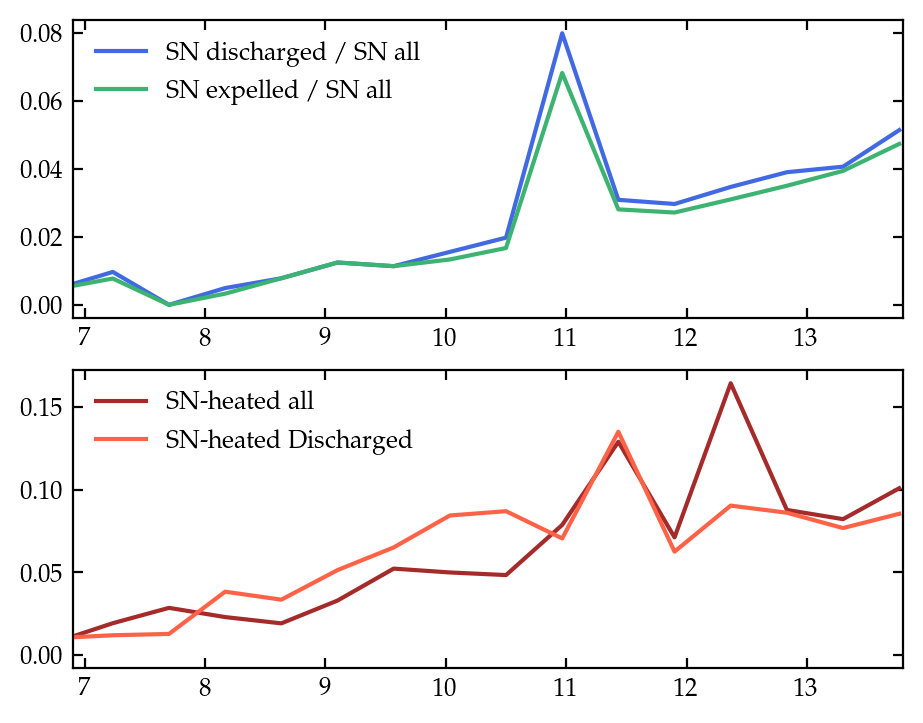

In [49]:
#fraction of discharged/heated (archive)
# all discharged gas
bins = 30
rangeMax = 14
dist, x = np.histogram(more_discharged.time, bins=bins, range=(0,rangeMax))

# all expelled gas
expt, x = np.histogram(more_expelled.time, bins=bins, range=(0,rangeMax))

# all snheated gas
snt, x = np.histogram(more_heated.time, bins=bins, range=(0,rangeMax))

# computing fraction dist/snt at each radial position.
fracDis = np.array([])
fracExp = np.array([])

for i in range(0, bins):
    ratioDis = dist[i]/snt[i]
    ratioExp = expt[i]/snt[i]
    fracDis = np.append(fracDis,ratioDis)
    fracExp = np.append(fracExp,ratioExp)
    i += 1


fig, ax = plt.subplots(2,1,figsize = (4.5,3.5))
# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax[0].plot(bincenters, fracDis, c = 'royalblue', label='SN discharged / SN all')
bincenters = 0.5*(x[1:] + x[:-1])
ax[0].plot(bincenters, fracExp, c = 'mediumseagreen', label='SN expelled / SN all')
ax[0].set_xlim(np.min(more_discharged.time), np.max(more_discharged.time))
ax[0].legend()

# mass distributions:
# all snheated gas
snt, x = np.histogram(more_heated.time, bins=bins, weights=wt(more_heated), range=(0,rangeMax))

_, discharged = read_one_discharged('h148_10')
heated = discharged[discharged['snHeated']==True]
sndischarged, x = np.histogram(heated.time, bins=bins, weights=wt(heated),range=(0,rangeMax))

bincenters = 0.5*(x[1:] + x[:-1])
ax[1].plot(bincenters, snt, label='SN-heated all', c='brown')
ax[1].plot(bincenters, sndischarged, label='SN-heated Discharged', c='tomato')
ax[1].set_xlim(np.min(more_discharged.time), np.max(more_discharged.time))
ax[1].legend()

In [61]:
np.unique(np.array([[1,2],[1,3],[1,3],[2,1]]), axis=0)

array([1, 2, 3])

In [155]:
a = np.array([1,2,3,4,5,6,7])
a[np.array([1,2])-1]

array([1, 2])

In [252]:
particles = read_tracked_particles(sim, haloid)
heated_all = calc_snHeated(particles)

> Returning <tracked_particle> dataset <


In [254]:
len(heated_all)

59402

In [255]:
len(heated_dis)

4600

In [263]:
_, data = read_one_discharged('h148_10')

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


In [275]:
data[(data['snHeated']==True)&(data['pid']==11128650)]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
191726,7.039793,11128650,0.014274,848226.437500,28737.282569,7.038629,1.890654,0.048105,1.257500,-1.266903,...,20.521985,False,False,False,False,False,True,1.519716e+10,135.178093,True
549904,8.608831,11128650,0.068709,10580.125000,21314.078491,8.494868,3.235061,0.069804,-2.949189,0.311034,...,20.248449,False,True,False,False,False,False,1.841544e+10,73.066572,True
728972,9.490994,11128650,0.007935,13453.203125,21397.014678,9.356826,5.665785,0.121458,4.394128,1.785799,...,18.284842,False,True,False,False,False,False,1.643150e+10,127.688814,True
907993,10.352954,11128650,0.029203,10850.455078,13550.131944,10.011713,6.535957,0.139540,5.873261,2.688814,...,18.796600,False,True,False,False,False,False,1.489011e+10,57.333581,True
1443902,12.150951,11128650,0.081856,9371.289062,13594.150831,12.111895,4.929128,0.103924,4.405070,1.758673,...,19.815729,False,True,False,False,False,False,1.288683e+10,64.431303,True
1621379,12.938837,11128650,0.001374,12028.806641,13736.994394,12.750788,12.050669,0.253640,-10.765113,1.411835,...,17.456248,False,True,False,False,False,False,1.215825e+10,19.806317,True


In [266]:
particles = read_tracked_particles('h148',10)
data2 = calc_snHeated(particles)

> Returning <tracked_particle> dataset <


In [285]:
test = particles[particles.pid==11128650]
# test = read_tracked_particles('h148', 10)
dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
testarray=np.array(list(zip(test.index, *map(test.get, ['pid','time','coolontime']))), dtype=dtype)
#print(testarray)
testarray=testarray[testarray['time']>testarray['coolontime']]
helper1, helper2 = np.unique(testarray['coolontime'], return_index = True)
testunique = np.sort(testarray[helper2], order=['pid','time'])
print(testunique)
pids = np.unique(testunique['pid'])
index = np.array([])
for pid in pids:
    dat = testunique[testunique['pid']==pid]
    timebefore = dat['time'][:-1]
    heatedArray = dat[1:][dat['coolontime'][1:]>timebefore]
    heatedIndex = heatedArray['index'].astype(int)
    index = np.append(index, heatedIndex)
heated = test[test.index.isin(index)]  

> Returning <tracked_particle> dataset <
[(     0,   376519, 6.47413103, 0.        )
 (     1,   419298, 6.47413103, 3.59668698)
 (268656,   702739, 7.33609179, 7.25832746) ...
 ( 89508, 20547672, 6.47413103, 4.93559639)
 ( 89512, 20564801, 6.47413103, 6.40874561)
 ( 89533, 20692705, 6.47413103, 4.18928351)]


In [288]:
#remake this function
#iterate detection process by pids

index = np.array([]) #initialize

data = particles[particles['pid']==11128650]
#create a structured array, containing index of dataframe, pid, time, and coolontime
dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
structureArray=np.array(list(zip(data.index, *map(data.get, ['pid','time','coolontime']))), dtype=dtype)
#limit to after being heated (avoid mistakingly take the row heated at the same timestep)
heatedArray=structureArray[structureArray['time']>structureArray['coolontime']]
#extract the list of unique coolontime, sorted by pid and time
helper1, helper2 = np.unique(heatedArray['coolontime'], return_index = True)
heatedunique = np.sort(heatedArray[helper2], order=['pid','time'])

timebefore = heatedunique['time'][:-1]
#find sn-heated list by comparing the time before and coolontime
heatedLocal = heatedunique[1:][heatedunique['coolontime'][1:]>timebefore]
indexLocal = heatedLocal['index'].astype(int)
index = np.append(index, indexLocal)
#based on detected indices, find the designated rows from original dataframe
heated = particles[particles.index.isin(index)] 

In [289]:
heated[heated.pid == 11128650]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
191726,7.039793,11128650,0.014274,848226.437500,28737.282569,7.038629,1.890654,0.048105,1.257500,-1.266903,...,0.134681,0.808819,20.521985,False,False,False,False,False,True,1.519716e+10
370820,7.767072,11128650,0.225140,9764.855469,21080.136030,7.720452,1.643590,0.036507,-1.210065,1.091757,...,0.430980,1.052765,18.543060,True,False,False,False,False,False,1.962724e+10
549904,8.608831,11128650,0.068709,10580.125000,21314.078491,8.494868,3.235061,0.069804,-2.949189,0.311034,...,0.410778,2.677134,20.248449,False,True,False,False,False,False,1.841544e+10
728972,9.490994,11128650,0.007935,13453.203125,21397.014678,9.356826,5.665785,0.121458,4.394128,1.785799,...,0.430980,3.898846,18.284842,False,True,False,False,False,False,1.643150e+10
907993,10.352954,11128650,0.029203,10850.455078,13550.131944,10.011713,6.535957,0.139540,5.873261,2.688814,...,0.430980,1.948417,18.796600,False,True,False,False,False,False,1.489011e+10
1443902,12.150951,11128650,0.081856,9371.289062,13594.150831,12.111895,4.929128,0.103924,4.405070,1.758673,...,0.074075,2.438901,19.815729,False,True,False,False,False,False,1.288683e+10
1621379,12.938837,11128650,0.001374,12028.806641,13736.994394,12.750788,12.050669,0.253640,-10.765113,1.411835,...,0.430980,3.480204,17.456248,False,True,False,False,False,False,1.215825e+10


In [4]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
print(a[np.where((a > 3)&(a < 10))[0]])

[4 5 6 7 8 9]


In [9]:
filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/heated_all_particles.hdf5'
heated_all = pd.read_hdf(filepath, key='h148_10')
np.unique(heated_all.time)

array([ 6.90511141,  7.03979278,  7.33609179,  7.76707217,  8.19805255,
        8.60883073,  9.06001331,  9.49099369,  9.92197407, 10.35295445,
       10.76709966, 10.78393483, 11.21491521, 11.6458956 , 12.07687598,
       12.15095073, 12.50785636, 12.93883674, 13.36981712, 13.8007975 ])